<a href="https://colab.research.google.com/github/LLima25/Valuation/blob/main/Valuation_Tupy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install numpy_financial
!pip install yfinance
import numpy_financial as npf
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy import cov
from statistics import variance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
#Modelo de precificação das ações da empresa TUPY (TUPY3), uma multinacional brasileira do setor de metalurgia, para cada um dos anos de 2011 a 2015
#Para cada ano do estudo, vamos utilizar apenas os dados disponíveis na data em questão.
#Por fim, iremos comparar como foi o desempenho do preço das ações em relação ao valuation estimado de cada ano

df_dre = pd.read_excel("https://github.com/LLima25/Valuation/blob/main/tupy3.xlsx?raw=true", sheet_name="DRE")
df_dre = df_dre.set_index('DRE')

#Crescimento da receita no ano atual em relação ao ano anterior (2011/2010-1)
receita_g1 = (df_dre.loc["Receita Líquida",2011] / df_dre.loc["Receita Líquida", 2010]) - 1


In [77]:
#Estimação da DRE (Demonstração do Resultados) para os 5 anos seguintes ao ano atual (2011) com base no crescimento da receita calculado anteriormente e no tamanho de cada conta da dre em % da Receita de 2011
dre1 = pd.DataFrame.from_dict(df_dre[2011])
dre1.columns = ['2011']

#Criação de uma coluna que calcula a % de cada conta da dre em relação a Receita do ano de 2011
dre1["% da Receita"] = dre1 / dre1.iloc[0]

#Para estimar a DRE dos próximos anos vamos calcular a receita do ano seguinte crescendo na mesma proporção do crescimento de 2011 e utilizar as mesmas proporções de 2011 para as demais contas
#Com isso, a Receita 2012 = Receita 2011 * (1+Crescimento da Receita de 2011)
#Receita 2013 = Receita 2012 * (1+Crescimento da Receita de 2011)
#Para as demais contas da dre, utilizamos as proporções do ano base (2011) sobre a nova receita estimada
#Lucro Líquido 2012 = Receita 2012 * Margem de Lucro Líquido 2011
#Lucro Líquido 2013 = Receita 2013 * Margem de Lucro Líquido 2011

dre1['Ano 1'] = (dre1["2011"]["Receita Líquida"] * (1+receita_g1)) * dre1["% da Receita"]
dre1['Ano 2'] = (dre1["Ano 1"]["Receita Líquida"] * (1+receita_g1)) * dre1["% da Receita"]
dre1['Ano 3'] = (dre1["Ano 2"]["Receita Líquida"] * (1+receita_g1)) * dre1["% da Receita"]
dre1['Ano 4'] = (dre1["Ano 3"]["Receita Líquida"] * (1+receita_g1)) * dre1["% da Receita"]
dre1['Ano 5'] = (dre1["Ano 4"]["Receita Líquida"] * (1+receita_g1)) * dre1["% da Receita"]

In [78]:
#Estimação do BP (Balanço Patrimonail) para os 5 anos da projeção
df_bp = pd.read_excel("https://github.com/LLima25/Valuation/blob/main/tupy3.xlsx?raw=true", sheet_name="BP")
df_bp = df_bp.set_index('BP')
bp1 = pd.DataFrame.from_dict(df_bp[2011])
bp1.columns = ['2011']

#Criação de uma coluna que calcula a proporção de cada conta do BP em relação a Receita no ano de 2011
#Exemplo: Proporção de Caixa em 2011 = Caixa 2011 / Receita 2011
bp1['% da Receita'] = bp1 / dre1['2011'].iloc[0]

#Para estimar o BP dos próximos anos, utilizamos as proporções apresentadas no ano base(2011) para cada uma das contas do balanço sobre a receita estimada de cada ano
#Caixa 2012 = Receita 2012 * (Proporção de Caixa em 2011)
#Caixa 2013 = Receita 2013 * (Proporção de Caixa em 2011)
bp1['Ano 1'] = dre1['Ano 1']['Receita Líquida'] * bp1["% da Receita"]
bp1['Ano 2'] = dre1['Ano 2']['Receita Líquida'] * bp1["% da Receita"]
bp1['Ano 3'] = dre1['Ano 3']['Receita Líquida'] * bp1["% da Receita"]
bp1['Ano 4'] = dre1['Ano 4']['Receita Líquida'] * bp1["% da Receita"]
bp1['Ano 5'] = dre1['Ano 5']['Receita Líquida'] * bp1["% da Receita"]

In [79]:
#Estimação do FCFF (Fluxo de Caixa Livre para a Firma) de cada um dos anos da projeção
#Fluxo de caixa livre é o valor que sobra para a empresa depois de pagar todos os gastos da operação e investimentos
#É comom base nesse fluxo de caixa que vamos calcular o "valor justo" da empresa
#FCFF = NOPAT + Depreciação - (Contas a Receber + Estoques - Fornecedor) - Capex
#NOPAT = Lucro Operacional depois do pagamento dos impostos
#CAPEX = Investimento em bens de capital

FCFF1 = {}
FCFF1['Ano 1'] ={}
FCFF1['Ano 1']['NOPAT'] = dre1['Ano 1']['Lucro Operacional (EBIT)'] + dre1['Ano 1']['Imposto de Renda e CSLL']
FCFF1['Ano 1']['Depreciação e Amortização'] = dre1['Ano 1']['Depreciação e Amortização']
FCFF1['Ano 1']['Contas a Receber'] = bp1['Ano 1']['Contas a receber'] - bp1['2011']['Contas a receber']
FCFF1['Ano 1']['Estoques'] = bp1['Ano 1'].iloc[4] - bp1['2011'].iloc[4]
FCFF1['Ano 1']['Fornecedores'] = bp1['Ano 1']['Fornecedores'] - bp1['2011']['Fornecedores']
FCFF1['Ano 1']['CAPEX'] = bp1['Ano 1']['Imobilizado'] - bp1['2011']['Imobilizado']
FCFF1['Ano 1']['FCFF'] = FCFF1['Ano 1']['NOPAT'] + FCFF1['Ano 1']['Depreciação e Amortização'] - FCFF1['Ano 1']['Contas a Receber'] - FCFF1['Ano 1']['Estoques'] + FCFF1['Ano 1']['Fornecedores'] - FCFF1['Ano 1']['CAPEX']

#FCFF Estimado do Ano 2
FCFF1['Ano 2'] ={}
FCFF1['Ano 2']['NOPAT'] = dre1['Ano 2']['Lucro Operacional (EBIT)'] + dre1['Ano 2']['Imposto de Renda e CSLL']
FCFF1['Ano 2']['Depreciação e Amortização'] = dre1['Ano 2']['Depreciação e Amortização']
FCFF1['Ano 2']['Contas a Receber'] = bp1['Ano 2']['Contas a receber'] - bp1['Ano 1']['Contas a receber']
FCFF1['Ano 2']['Estoques'] = bp1['Ano 2'].iloc[4] - bp1['Ano 1'].iloc[4]
FCFF1['Ano 2']['Fornecedores'] = bp1['Ano 2']['Fornecedores'] - bp1['Ano 1']['Fornecedores']
FCFF1['Ano 2']['CAPEX'] = bp1['Ano 2']['Imobilizado'] - bp1['Ano 1']['Imobilizado']
FCFF1['Ano 2']['FCFF'] = FCFF1['Ano 2']['NOPAT'] + FCFF1['Ano 2']['Depreciação e Amortização'] - FCFF1['Ano 2']['Contas a Receber'] - FCFF1['Ano 2']['Estoques'] + FCFF1['Ano 2']['Fornecedores'] - FCFF1['Ano 2']['CAPEX']

#FCFF Estimado do Ano 3
FCFF1['Ano 3'] ={}
FCFF1['Ano 3']['NOPAT'] = dre1['Ano 3']['Lucro Operacional (EBIT)'] + dre1['Ano 3']['Imposto de Renda e CSLL']
FCFF1['Ano 3']['Depreciação e Amortização'] = dre1['Ano 3']['Depreciação e Amortização']
FCFF1['Ano 3']['Contas a Receber'] = bp1['Ano 3']['Contas a receber'] - bp1['Ano 2']['Contas a receber']
FCFF1['Ano 3']['Estoques'] = bp1['Ano 3'].iloc[4] - bp1['Ano 2'].iloc[4]
FCFF1['Ano 3']['Fornecedores'] = bp1['Ano 3']['Fornecedores'] - bp1['Ano 2']['Fornecedores']
FCFF1['Ano 3']['CAPEX'] = bp1['Ano 3']['Imobilizado'] - bp1['Ano 2']['Imobilizado']
FCFF1['Ano 3']['FCFF'] = FCFF1['Ano 3']['NOPAT'] + FCFF1['Ano 3']['Depreciação e Amortização'] - FCFF1['Ano 3']['Contas a Receber'] - FCFF1['Ano 3']['Estoques'] + FCFF1['Ano 3']['Fornecedores'] - FCFF1['Ano 3']['CAPEX']

#FCFF Estimado do Ano 4
FCFF1['Ano 4'] ={}
FCFF1['Ano 4']['NOPAT'] = dre1['Ano 4']['Lucro Operacional (EBIT)'] + dre1['Ano 4']['Imposto de Renda e CSLL']
FCFF1['Ano 4']['Depreciação e Amortização'] = dre1['Ano 4']['Depreciação e Amortização']
FCFF1['Ano 4']['Contas a Receber'] = bp1['Ano 4']['Contas a receber'] - bp1['Ano 3']['Contas a receber']
FCFF1['Ano 4']['Estoques'] = bp1['Ano 4'].iloc[4] - bp1['Ano 3'].iloc[4]
FCFF1['Ano 4']['Fornecedores'] = bp1['Ano 4']['Fornecedores'] - bp1['Ano 3']['Fornecedores']
FCFF1['Ano 4']['CAPEX'] = bp1['Ano 4']['Imobilizado'] - bp1['Ano 3']['Imobilizado']
FCFF1['Ano 4']['FCFF'] = FCFF1['Ano 4']['NOPAT'] + FCFF1['Ano 4']['Depreciação e Amortização'] - FCFF1['Ano 4']['Contas a Receber'] - FCFF1['Ano 4']['Estoques'] + FCFF1['Ano 4']['Fornecedores'] - FCFF1['Ano 4']['CAPEX']

#FCFF Estimado do Ano 5
FCFF1['Ano 5'] ={}
FCFF1['Ano 5']['NOPAT'] = dre1['Ano 5']['Lucro Operacional (EBIT)'] + dre1['Ano 5']['Imposto de Renda e CSLL']
FCFF1['Ano 5']['Depreciação e Amortização'] = dre1['Ano 5']['Depreciação e Amortização']
FCFF1['Ano 5']['Contas a Receber'] = bp1['Ano 5']['Contas a receber'] - bp1['Ano 4']['Contas a receber']
FCFF1['Ano 5']['Estoques'] = bp1['Ano 5'].iloc[4] - bp1['Ano 4'].iloc[4]
FCFF1['Ano 5']['Fornecedores'] = bp1['Ano 5']['Fornecedores'] - bp1['Ano 4']['Fornecedores']
FCFF1['Ano 5']['CAPEX'] = bp1['Ano 5']['Imobilizado'] - bp1['Ano 4']['Imobilizado']
FCFF1['Ano 5']['FCFF'] = FCFF1['Ano 5']['NOPAT'] + FCFF1['Ano 5']['Depreciação e Amortização'] - FCFF1['Ano 5']['Contas a Receber'] - FCFF1['Ano 5']['Estoques'] + FCFF1['Ano 5']['Fornecedores'] - FCFF1['Ano 5']['CAPEX']

#Valor gasto com CAPEX em relação a Receita Líquida
capexrate = FCFF1['Ano 5']['CAPEX'] / dre1['Ano 5']['Receita Líquida']

#Converter em pandas
FCFF_1 = pd.DataFrame.from_dict(FCFF1,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

Na próxima etapa, iremos medir o Custo Médio Ponderado de Capital (WACC):

\begin{align}
        WACC = (kd(1-T)Debt) + (ke * Equity)
    \end{align}
    
onde,

kd = custo de capital de terceiro

ke = custo de capital próprio

T = Taxa de Impostos

Para calcular o ke, utilizarem o CAPM (Capital Asset Pricing Model)
\begin{align}
        ke = Rf + b *(Rm - Rf)
    \end{align}

onde, 

Rf = Taxa Livre de Risco

b = Beta

Rm = Retorno de mercado

Já para calcular o beta, utilizaremos a seguinte fórmula:

\begin{align}
        Beta = \frac{cov(Ra,Rm)}{var Rm}
    \end{align}

onde,

Ra = Retorno do Ativo analisado

In [80]:
#Calcular o Custo Médio Ponderado de Capital (WACC):
#É a taxa que usaremos para descontar para valor presente as projeções futuras de fluxo de caixa

#Beta com a %Retorno diário de TUPY e do IBOV nos últimos 12 meses
#Beta é uma medida de volatilidade de um ativo em relação ao mercado como um todo
retorno1_1 = yf.download(["^BVSP", "TUPY3.SA"],start='2011-01-01',end='2011-12-31')["Close"]
retorno1_1.columns = ['TUPY3', 'IBOV']
retorno1_1['% IBOV'] = retorno1_1["IBOV"].pct_change()
retorno1_1["% TUPY3"] = retorno1_1["TUPY3"].pct_change()
retorno1_1 = retorno1_1[1:]


beta1_1 = retorno1_1["% TUPY3"].cov(retorno1_1["% IBOV"]) / retorno1_1["% IBOV"].var()


#Beta com a %Retorno mensal de TUPY e IBOV nos últimos 36 meses
retorno2_1 = yf.download(['^BVSP', 'TUPY3.SA'], start='2009-01-01', end='2011-12-31',interval='1mo')['Close']
retorno2_1.columns = ['TUPY3', 'IBOV']
retorno2_1['% IBOV'] = retorno2_1["IBOV"].pct_change()
retorno2_1["% TUPY3"] = retorno2_1["TUPY3"].pct_change()
retorno2_1 = retorno2_1[1:]

beta2_1 = retorno2_1["% TUPY3"].cov(retorno2_1["% IBOV"]) / retorno2_1["% IBOV"].var()

#Para a Taxa Livre de Risco (RF) utilizaremos a selic no final de cada ano estudado
#Já para o Retorno de Mercado (RM) iremos usar a Rentabilidade Média Anual aproximada do Ibovespa nos últimos 50 anos
RF = 0.1090
RM = 0.07

premio_risco1 = RM - RF

#CAPM = RF + (beta * (RM - RF))
#CAPM 1 utiliza o beta 12 meses
#CAPM 2 utiliza o beta 36 meses
CAPM1_1 = RF + (beta1_1 * premio_risco1)
CAPM2_1 = RF + (beta2_1 * premio_risco1)

#Para calcular o Custo de Capital de Terceiros (Kd), iremos utilizar o Custo da Dívida: kd1 = Despesa Financeira / Dívida Total
divida1 = bp1['2011']['Dividas Curto Prazo'] + bp1['2011']['Dividas Longo Prazo']
kd1 = dre1['2011']['Despesas Financeiras'] / divida1

#Estrutura de Capital
#Proporção de Dívida = Divida/(Divida + Equity)
#Proporção de Capital Próprio = Equity/(Divida + Equity)
debt1 = divida1 / (divida1 + bp1['2011']['Patrimônio Líquido'])
equity1 = bp1['2011']['Patrimônio Líquido'] / (divida1 + bp1['2011']['Patrimônio Líquido'])

#WACC = (kd*(1-T)*Debt) + (ke*Equity)
#T (Tax Rate)= Taxa de Imposto IRPJ/CSLL Brasil (34% no Brasil)
tax_rate = 0.34
wacc1_1 = ((kd1*(-1))*(1-tax_rate)*debt1) + (CAPM1_1*equity1)
wacc2_1 = ((kd1*-1)*(1-tax_rate)*debt1) + (CAPM2_1*equity1)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Finalmente, para conseguirmos chegar ao preço estimado do ativo iremos calcular o valor da empresa na perpetuidade e o valor presente dos fluxos de caixa futuro.


Para a perpetuidade, iremos utilizar a seguinte equação:
\begin{align}
        Perpetuidade = \frac{FCFF (1+g)}{(WACC-g)}
    \end{align}

onde,

g = Crescimento da Empresa na Perpetuidade

Já para encontrar o valor presente dos fluxos de caixa, iremos calcular da seguinte forma:
\begin{align}
        NPV =  \sum_{i=1}^n \frac{FCFFi}{(1+WACC)^i}
    \end{align}


In [81]:
#Perpetuidade
#Para calcularmos o preço justo da ação, consideramos que a empresa irá continuar a operar eternamente depois da última data projeta, de forma que precisamos calcular seu valor na perpetuidade.
#Para a formula da perpetuidade, utilizaremos o g(crescimento da empresa na perpetuidade) como sendo igual a inflação de longo prazo medido pelo FOCUS (Mediana das expectativas de mercado).
TV1_g = 0.03

TV1_1 = (FCFF1['Ano 5']['FCFF'] * (1+TV1_g)) / (wacc1_1 - TV1_g)
TV1p1_1 = TV1_1 / ((1+wacc1_1)**5)

TV2_1 = (FCFF1['Ano 5']['FCFF'] * (1+TV1_g)) / (wacc2_1 - TV1_g)
TV1p2_1 = TV2_1 / ((1+wacc2_1)**5)

#Com a taxa de desconto e os fluxos de caixa calculado, vamos calcular o NPV(valor presente líquidos) dos fluxos de caixa estimado, ou seja, qual o valor de cada um desses fluxos na data atual.
FCFF_Lista1 = FCFF_1.iloc[-1].values.tolist()
NPV1_1 = npf.npv(wacc1_1,FCFF_Lista1)
NPV2_1 = npf.npv(wacc2_1,FCFF_Lista1)

#Por fim, para calcular o valor da firma iremos somar o NPV com a perpetuidade: EV = NPV + Perpetuidade
EV1_1 = TV1p1_1 + NPV1_1

EV2_1 = TV1p2_1 + NPV2_1


#Preço da Ação = (EV + Caixa - Dívida) / Ações

#Ações = Numero total de ações emitidas da empresa no período estudado

Ações1 = 114000

#Preço1_1 = Beta 12 meses
#Preço2_1 = Beta 36 meses
Preço1_1 = (EV1_1 - divida1 + bp1['2011']['Caixa e equivalentes']) / Ações1
Preço2_1 = (EV2_1 - divida1 + bp1['2011']['Caixa e equivalentes']) / Ações1

In [82]:
#Repetição de todo o processo realizado acima para os próximos
#Projeção do Target Price 2012

receita_g2 = (df_dre.loc["Receita Líquida",2012] / df_dre.loc["Receita Líquida", 2011]) - 1

dre2 = pd.DataFrame.from_dict(df_dre[2012])
dre2.columns = ['2012']
dre2["% da Receita"] = dre2 / dre2.iloc[0]
dre2['Ano 1'] = (dre2["2012"]["Receita Líquida"] * (1+receita_g2)) * dre2["% da Receita"]
dre2['Ano 2'] = (dre2["Ano 1"]["Receita Líquida"] * (1+receita_g2)) * dre2["% da Receita"]
dre2['Ano 3'] = (dre2["Ano 2"]["Receita Líquida"] * (1+receita_g2)) * dre2["% da Receita"]
dre2['Ano 4'] = (dre2["Ano 3"]["Receita Líquida"] * (1+receita_g2)) * dre2["% da Receita"]
dre2['Ano 5'] = (dre2["Ano 4"]["Receita Líquida"] * (1+receita_g2)) * dre2["% da Receita"]


bp2 = pd.DataFrame.from_dict(df_bp[2012])
bp2.columns = ['2012']
bp2['% da Receita'] = bp2 / dre2['2012'].iloc[0]


bp2['Ano 1'] = dre2['Ano 1']['Receita Líquida'] * bp2["% da Receita"]
bp2['Ano 2'] = dre2['Ano 2']['Receita Líquida'] * bp2["% da Receita"]
bp2['Ano 3'] = dre2['Ano 3']['Receita Líquida'] * bp2["% da Receita"]
bp2['Ano 4'] = dre2['Ano 4']['Receita Líquida'] * bp2["% da Receita"]
bp2['Ano 5'] = dre2['Ano 5']['Receita Líquida'] * bp2["% da Receita"]


FCFF2 = {}
FCFF2['Ano 1'] ={}
FCFF2['Ano 1']['NOPAT'] = dre2['Ano 1']['Lucro Operacional (EBIT)'] + dre2['Ano 1']['Imposto de Renda e CSLL']
FCFF2['Ano 1']['Depreciação e Amortização'] = dre2['Ano 1']['Depreciação e Amortização']
FCFF2['Ano 1']['Contas a Receber'] = bp2['Ano 1']['Contas a receber'] - bp2['2012']['Contas a receber']
FCFF2['Ano 1']['Estoques'] = bp2['Ano 1'].iloc[4] - bp2['2012'].iloc[4]
FCFF2['Ano 1']['Fornecedores'] = bp2['Ano 1']['Fornecedores'] - bp2['2012']['Fornecedores']
FCFF2['Ano 1']['CAPEX'] = dre2['Ano 1']['Receita Líquida'] * capexrate
FCFF2['Ano 1']['FCFF'] = FCFF2['Ano 1']['NOPAT'] + FCFF2['Ano 1']['Depreciação e Amortização'] - FCFF2['Ano 1']['Contas a Receber'] - FCFF2['Ano 1']['Estoques'] + FCFF2['Ano 1']['Fornecedores'] - FCFF2['Ano 1']['CAPEX']

FCFF2['Ano 2'] ={}
FCFF2['Ano 2']['NOPAT'] = dre2['Ano 2']['Lucro Operacional (EBIT)'] + dre2['Ano 2']['Imposto de Renda e CSLL']
FCFF2['Ano 2']['Depreciação e Amortização'] = dre2['Ano 2']['Depreciação e Amortização']
FCFF2['Ano 2']['Contas a Receber'] = bp2['Ano 2']['Contas a receber'] - bp2['Ano 1']['Contas a receber']
FCFF2['Ano 2']['Estoques'] = bp2['Ano 2'].iloc[4] - bp2['Ano 1'].iloc[4]
FCFF2['Ano 2']['Fornecedores'] = bp2['Ano 2']['Fornecedores'] - bp2['Ano 1']['Fornecedores']
FCFF2['Ano 2']['CAPEX'] = dre2['Ano 2']['Receita Líquida'] * capexrate
FCFF2['Ano 2']['FCFF'] = FCFF2['Ano 2']['NOPAT'] + FCFF2['Ano 2']['Depreciação e Amortização'] - FCFF2['Ano 2']['Contas a Receber'] - FCFF2['Ano 2']['Estoques'] + FCFF2['Ano 2']['Fornecedores'] - FCFF2['Ano 2']['CAPEX']

FCFF2['Ano 3'] ={}
FCFF2['Ano 3']['NOPAT'] = dre2['Ano 3']['Lucro Operacional (EBIT)'] + dre2['Ano 3']['Imposto de Renda e CSLL']
FCFF2['Ano 3']['Depreciação e Amortização'] = dre2['Ano 3']['Depreciação e Amortização']
FCFF2['Ano 3']['Contas a Receber'] = bp2['Ano 3']['Contas a receber'] - bp2['Ano 2']['Contas a receber']
FCFF2['Ano 3']['Estoques'] = bp2['Ano 3'].iloc[4] - bp2['Ano 2'].iloc[4]
FCFF2['Ano 3']['Fornecedores'] = bp2['Ano 3']['Fornecedores'] - bp2['Ano 2']['Fornecedores']
FCFF2['Ano 3']['CAPEX'] = dre2['Ano 3']['Receita Líquida'] * capexrate
FCFF2['Ano 3']['FCFF'] = FCFF2['Ano 3']['NOPAT'] + FCFF2['Ano 3']['Depreciação e Amortização'] - FCFF2['Ano 3']['Contas a Receber'] - FCFF2['Ano 3']['Estoques'] + FCFF2['Ano 3']['Fornecedores'] - FCFF2['Ano 3']['CAPEX']

FCFF2['Ano 4'] ={}
FCFF2['Ano 4']['NOPAT'] = dre2['Ano 4']['Lucro Operacional (EBIT)'] + dre2['Ano 4']['Imposto de Renda e CSLL']
FCFF2['Ano 4']['Depreciação e Amortização'] = dre2['Ano 4']['Depreciação e Amortização']
FCFF2['Ano 4']['Contas a Receber'] = bp2['Ano 4']['Contas a receber'] - bp2['Ano 3']['Contas a receber']
FCFF2['Ano 4']['Estoques'] = bp2['Ano 4'].iloc[4] - bp2['Ano 3'].iloc[4]
FCFF2['Ano 4']['Fornecedores'] = bp2['Ano 4']['Fornecedores'] - bp2['Ano 3']['Fornecedores']
FCFF2['Ano 4']['CAPEX'] = dre2['Ano 4']['Receita Líquida'] * capexrate
FCFF2['Ano 4']['FCFF'] = FCFF2['Ano 4']['NOPAT'] + FCFF2['Ano 4']['Depreciação e Amortização'] - FCFF2['Ano 4']['Contas a Receber'] - FCFF2['Ano 4']['Estoques'] + FCFF2['Ano 4']['Fornecedores'] - FCFF2['Ano 4']['CAPEX']

FCFF2['Ano 5'] ={}
FCFF2['Ano 5']['NOPAT'] = dre2['Ano 5']['Lucro Operacional (EBIT)'] + dre2['Ano 5']['Imposto de Renda e CSLL']
FCFF2['Ano 5']['Depreciação e Amortização'] = dre2['Ano 5']['Depreciação e Amortização']
FCFF2['Ano 5']['Contas a Receber'] = bp2['Ano 5']['Contas a receber'] - bp2['Ano 4']['Contas a receber']
FCFF2['Ano 5']['Estoques'] = bp2['Ano 5'].iloc[4] - bp2['Ano 4'].iloc[4]
FCFF2['Ano 5']['Fornecedores'] = bp2['Ano 5']['Fornecedores'] - bp2['Ano 4']['Fornecedores']
FCFF2['Ano 5']['CAPEX'] = dre2['Ano 5']['Receita Líquida'] * capexrate
FCFF2['Ano 5']['FCFF'] = FCFF2['Ano 5']['NOPAT'] + FCFF2['Ano 5']['Depreciação e Amortização'] - FCFF2['Ano 5']['Contas a Receber'] - FCFF2['Ano 5']['Estoques'] + FCFF2['Ano 5']['Fornecedores'] - FCFF2['Ano 5']['CAPEX']

FCFF_2 = pd.DataFrame.from_dict(FCFF2,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format


retorno1_2 = yf.download(["^BVSP", "TUPY3.SA"],start='2012-01-01',end='2012-12-31')["Close"]
retorno1_2.columns = ['TUPY3', 'IBOV']
retorno1_2['% IBOV'] = retorno1_2["IBOV"].pct_change()
retorno1_2["% TUPY3"] = retorno1_2["TUPY3"].pct_change()
retorno1_2 = retorno1_2[1:]

beta1_2 = retorno1_2["% TUPY3"].cov(retorno1_2["% IBOV"]) / retorno1_2["% IBOV"].var()

retorno2_2 = yf.download(['^BVSP', 'TUPY3.SA'], start='2010-01-01', end='2012-12-31',interval='1mo')['Close']
retorno2_2.columns = ['TUPY3', 'IBOV']
retorno2_2['% IBOV'] = retorno2_2["IBOV"].pct_change()
retorno2_2["% TUPY3"] = retorno2_2["TUPY3"].pct_change()
retorno2_2 = retorno2_2[1:]

beta2_2 = retorno2_2["% TUPY3"].cov(retorno2_2["% IBOV"]) / retorno2_2["% IBOV"].var()


RF = 0.0725
RM = 0.07

premio_risco2 = RM - RF


CAPM1_2 = RF + (beta1_2 * premio_risco2)
CAPM2_2 = RF + (beta2_2 * premio_risco2)



divida2 = bp2['2012']['Dividas Curto Prazo'] + bp2['2012']['Dividas Longo Prazo']
kd2 = dre2['2012']['Despesas Financeiras'] / divida2


debt2 = divida2 / (divida2 + bp2['2012']['Patrimônio Líquido'])
equity2 = bp2['2012']['Patrimônio Líquido'] / (divida2 + bp2['2012']['Patrimônio Líquido'])


tax_rate = 0.34
wacc1_2 = ((kd2*-1)*(1-tax_rate)*debt2) + (CAPM1_2*equity2)
wacc2_2 = ((kd2*-1)*(1-tax_rate)*debt2) + (CAPM2_2*equity2)

TV2_g = 0.03
TV1_2 = (FCFF2['Ano 5']['FCFF'] * (1+TV2_g)) / (wacc1_2 - TV2_g)
TV2p1_2 = TV1_2 / ((1+wacc1_2)**5)

TV2_2 = (FCFF2['Ano 5']['FCFF'] * (1+TV2_g)) / (wacc2_2 - TV2_g)
TV2p2_2 = TV2_2 / ((1+wacc2_2)**5)

FCFF_Lista2 = FCFF_2.iloc[-1].values.tolist()
NPV1_2 = npf.npv(wacc1_2,FCFF_Lista2)
NPV2_2 = npf.npv(wacc2_2,FCFF_Lista2)

EV1_2 = TV2p1_2 + NPV1_2
EV2_2 = TV2p2_2 + NPV2_2

Ações2 = 114000
Preço1_2 = (EV1_2 - divida2 + bp2['2012']['Caixa e equivalentes']) / Ações2
Preço2_2 = (EV2_2 - divida2 + bp2['2012']['Caixa e equivalentes']) / Ações2

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [83]:
#Projeção do Target Price 2013

receita_g3 = (df_dre.loc["Receita Líquida",2013] / df_dre.loc["Receita Líquida", 2012]) - 1

dre3 = pd.DataFrame.from_dict(df_dre[2013])
dre3.columns = ['2013']
dre3["% da Receita"] = dre3 / dre3.iloc[0]
dre3['Ano 1'] = (dre3["2013"]["Receita Líquida"] * (1+receita_g3)) * dre3["% da Receita"]
dre3['Ano 2'] = (dre3["Ano 1"]["Receita Líquida"] * (1+receita_g3)) * dre3["% da Receita"]
dre3['Ano 3'] = (dre3["Ano 2"]["Receita Líquida"] * (1+receita_g3)) * dre3["% da Receita"]
dre3['Ano 4'] = (dre3["Ano 3"]["Receita Líquida"] * (1+receita_g3)) * dre3["% da Receita"]
dre3['Ano 5'] = (dre3["Ano 4"]["Receita Líquida"] * (1+receita_g3)) * dre3["% da Receita"]


bp3 = pd.DataFrame.from_dict(df_bp[2013])
bp3.columns = ['2013']
bp3['% da Receita'] = bp3 / dre3['2013'].iloc[0]


bp3['Ano 1'] = dre3['Ano 1']['Receita Líquida'] * bp3["% da Receita"]
bp3['Ano 2'] = dre3['Ano 2']['Receita Líquida'] * bp3["% da Receita"]
bp3['Ano 3'] = dre3['Ano 3']['Receita Líquida'] * bp3["% da Receita"]
bp3['Ano 4'] = dre3['Ano 4']['Receita Líquida'] * bp3["% da Receita"]
bp3['Ano 5'] = dre3['Ano 5']['Receita Líquida'] * bp3["% da Receita"]


FCFF3 = {}
FCFF3['Ano 1'] ={}
FCFF3['Ano 1']['NOPAT'] = dre3['Ano 1']['Lucro Operacional (EBIT)'] + dre3['Ano 1']['Imposto de Renda e CSLL']
FCFF3['Ano 1']['Depreciação e Amortização'] = dre3['Ano 1']['Depreciação e Amortização']
FCFF3['Ano 1']['Contas a Receber'] = bp3['Ano 1']['Contas a receber'] - bp3['2013']['Contas a receber']
FCFF3['Ano 1']['Estoques'] = bp3['Ano 1'].iloc[4] - bp3['2013'].iloc[4]
FCFF3['Ano 1']['Fornecedores'] = bp3['Ano 1']['Fornecedores'] - bp3['2013']['Fornecedores']
FCFF3['Ano 1']['CAPEX'] = dre3['Ano 1']['Receita Líquida'] * capexrate
FCFF3['Ano 1']['FCFF'] = FCFF3['Ano 1']['NOPAT'] + FCFF3['Ano 1']['Depreciação e Amortização'] - FCFF3['Ano 1']['Contas a Receber'] - FCFF3['Ano 1']['Estoques'] + FCFF3['Ano 1']['Fornecedores'] - FCFF3['Ano 1']['CAPEX']

FCFF3['Ano 2'] ={}
FCFF3['Ano 2']['NOPAT'] = dre3['Ano 2']['Lucro Operacional (EBIT)'] + dre3['Ano 2']['Imposto de Renda e CSLL']
FCFF3['Ano 2']['Depreciação e Amortização'] = dre3['Ano 2']['Depreciação e Amortização']
FCFF3['Ano 2']['Contas a Receber'] = bp3['Ano 2']['Contas a receber'] - bp3['Ano 1']['Contas a receber']
FCFF3['Ano 2']['Estoques'] = bp3['Ano 2'].iloc[4] - bp3['Ano 1'].iloc[4]
FCFF3['Ano 2']['Fornecedores'] = bp3['Ano 2']['Fornecedores'] - bp3['Ano 1']['Fornecedores']
FCFF3['Ano 2']['CAPEX'] = dre3['Ano 2']['Receita Líquida'] * capexrate
FCFF3['Ano 2']['FCFF'] = FCFF3['Ano 2']['NOPAT'] + FCFF3['Ano 2']['Depreciação e Amortização'] - FCFF3['Ano 2']['Contas a Receber'] - FCFF3['Ano 2']['Estoques'] + FCFF3['Ano 2']['Fornecedores'] - FCFF3['Ano 2']['CAPEX']

FCFF3['Ano 3'] ={}
FCFF3['Ano 3']['NOPAT'] = dre3['Ano 3']['Lucro Operacional (EBIT)'] + dre3['Ano 3']['Imposto de Renda e CSLL']
FCFF3['Ano 3']['Depreciação e Amortização'] = dre3['Ano 3']['Depreciação e Amortização']
FCFF3['Ano 3']['Contas a Receber'] = bp3['Ano 3']['Contas a receber'] - bp3['Ano 2']['Contas a receber']
FCFF3['Ano 3']['Estoques'] = bp3['Ano 3'].iloc[4] - bp3['Ano 2'].iloc[4]
FCFF3['Ano 3']['Fornecedores'] = bp3['Ano 3']['Fornecedores'] - bp3['Ano 2']['Fornecedores']
FCFF3['Ano 3']['CAPEX'] = dre3['Ano 3']['Receita Líquida'] * capexrate
FCFF3['Ano 3']['FCFF'] = FCFF3['Ano 3']['NOPAT'] + FCFF3['Ano 3']['Depreciação e Amortização'] - FCFF3['Ano 3']['Contas a Receber'] - FCFF3['Ano 3']['Estoques'] + FCFF3['Ano 3']['Fornecedores'] - FCFF3['Ano 3']['CAPEX']

FCFF3['Ano 4'] ={}
FCFF3['Ano 4']['NOPAT'] = dre3['Ano 4']['Lucro Operacional (EBIT)'] + dre3['Ano 4']['Imposto de Renda e CSLL']
FCFF3['Ano 4']['Depreciação e Amortização'] = dre3['Ano 4']['Depreciação e Amortização']
FCFF3['Ano 4']['Contas a Receber'] = bp3['Ano 4']['Contas a receber'] - bp3['Ano 3']['Contas a receber']
FCFF3['Ano 4']['Estoques'] = bp3['Ano 4'].iloc[4] - bp3['Ano 3'].iloc[4]
FCFF3['Ano 4']['Fornecedores'] = bp3['Ano 4']['Fornecedores'] - bp3['Ano 3']['Fornecedores']
FCFF3['Ano 4']['CAPEX'] = dre3['Ano 4']['Receita Líquida'] * capexrate
FCFF3['Ano 4']['FCFF'] = FCFF3['Ano 4']['NOPAT'] + FCFF3['Ano 4']['Depreciação e Amortização'] - FCFF3['Ano 4']['Contas a Receber'] - FCFF3['Ano 4']['Estoques'] + FCFF3['Ano 4']['Fornecedores'] - FCFF3['Ano 4']['CAPEX']

FCFF3['Ano 5'] ={}
FCFF3['Ano 5']['NOPAT'] = dre3['Ano 5']['Lucro Operacional (EBIT)'] + dre3['Ano 5']['Imposto de Renda e CSLL']
FCFF3['Ano 5']['Depreciação e Amortização'] = dre3['Ano 5']['Depreciação e Amortização']
FCFF3['Ano 5']['Contas a Receber'] = bp3['Ano 5']['Contas a receber'] - bp3['Ano 4']['Contas a receber']
FCFF3['Ano 5']['Estoques'] = bp3['Ano 5'].iloc[4] - bp3['Ano 4'].iloc[4]
FCFF3['Ano 5']['Fornecedores'] = bp3['Ano 5']['Fornecedores'] - bp3['Ano 4']['Fornecedores']
FCFF3['Ano 5']['CAPEX'] = dre3['Ano 5']['Receita Líquida'] * capexrate
FCFF3['Ano 5']['FCFF'] = FCFF3['Ano 5']['NOPAT'] + FCFF3['Ano 5']['Depreciação e Amortização'] - FCFF3['Ano 5']['Contas a Receber'] - FCFF3['Ano 5']['Estoques'] + FCFF3['Ano 5']['Fornecedores'] - FCFF3['Ano 5']['CAPEX']

FCFF_3 = pd.DataFrame.from_dict(FCFF3,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format


retorno1_3 = yf.download(["^BVSP", "TUPY3.SA"],start='2013-01-01',end='2013-12-31')["Close"]
retorno1_3.columns = ['TUPY3', 'IBOV']
retorno1_3['% IBOV'] = retorno1_3["IBOV"].pct_change()
retorno1_3["% TUPY3"] = retorno1_3["TUPY3"].pct_change()
retorno1_3 = retorno1_3[1:]

beta1_3 = retorno1_3["% TUPY3"].cov(retorno1_3["% IBOV"]) / retorno1_3["% IBOV"].var()

retorno2_3 = yf.download(["^BVSP", "TUPY3.SA"],start='2011-01-01',end='2013-12-31',interval='1mo')["Close"]
retorno2_3.columns = ['TUPY3', 'IBOV']
retorno2_3['% IBOV'] = retorno2_3["IBOV"].pct_change()
retorno2_3["% TUPY3"] = retorno2_3["TUPY3"].pct_change()
retorno2_3 = retorno2_3[1:]

beta2_3 = retorno2_3["% TUPY3"].cov(retorno2_3["% IBOV"]) / retorno2_3["% IBOV"].var()


RF = 0.10
RM = 0.07

premio_risco3 = RM - RF


CAPM1_3 = RF + (beta1_3 * premio_risco3)
CAPM2_3 = RF + (beta2_3 * premio_risco3)

divida3 = bp3['2013']['Dividas Curto Prazo'] + bp3['2013']['Dividas Longo Prazo']
kd3 = dre3['2013']['Despesas Financeiras'] / divida3


debt3 = divida3 / (divida3 + bp3['2013']['Patrimônio Líquido'])
equity3 = bp3['2013']['Patrimônio Líquido'] / (divida3 + bp3['2013']['Patrimônio Líquido'])


tax_rate = 0.34
wacc1_3 = ((kd3*-1)*(1-tax_rate)*debt3) + (CAPM1_3*equity3)
wacc2_3 = ((kd3*-1)*(1-tax_rate)*debt3) + (CAPM2_3*equity3)

TV3_g = 0.03
TV1_3 = (FCFF3['Ano 5']['FCFF'] * (1+TV3_g)) / (wacc1_3 - TV3_g)
TV3p1_3 = TV1_3 / ((1+wacc1_3)**5)

TV3_g = 0.03
TV2_3 = (FCFF3['Ano 5']['FCFF'] * (1+TV3_g)) / (wacc2_3 - TV3_g)
TV3p2_3 = TV2_3 / ((1+wacc2_3)**5)

FCFF_Lista3 = FCFF_3.iloc[-1].values.tolist()
NPV1_3 = npf.npv(wacc1_3,FCFF_Lista3)
NPV2_3 = npf.npv(wacc2_3,FCFF_Lista3)

EV1_3 = TV3p1_3 + NPV1_3
EV2_3 = TV3p2_3 + NPV2_3

Ações3 = 144000
Preço1_3 = (EV1_3 - divida3 + bp3['2013']['Caixa e equivalentes']) / Ações3
Preço2_3 = (EV2_3 - divida3 + bp3['2013']['Caixa e equivalentes']) / Ações3

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [84]:
#Projeção do Target Price 2014

receita_g4 = (df_dre.loc["Receita Líquida",2014] / df_dre.loc["Receita Líquida", 2013]) - 1

dre4 = pd.DataFrame.from_dict(df_dre[2014])
dre4.columns = ['2014']
dre4["% da Receita"] = dre4 / dre4.iloc[0]
dre4['Ano 1'] = (dre4["2014"]["Receita Líquida"] * (1+receita_g3)) * dre4["% da Receita"]
dre4['Ano 2'] = (dre4["Ano 1"]["Receita Líquida"] * (1+receita_g3)) * dre4["% da Receita"]
dre4['Ano 3'] = (dre4["Ano 2"]["Receita Líquida"] * (1+receita_g3)) * dre4["% da Receita"]
dre4['Ano 4'] = (dre4["Ano 3"]["Receita Líquida"] * (1+receita_g3)) * dre4["% da Receita"]
dre4['Ano 5'] = (dre4["Ano 4"]["Receita Líquida"] * (1+receita_g3)) * dre4["% da Receita"]


bp4 = pd.DataFrame.from_dict(df_bp[2014])
bp4.columns = ['2014']
bp4['% da Receita'] = bp4 / dre4['2014'].iloc[0]


bp4['Ano 1'] = dre4['Ano 1']['Receita Líquida'] * bp4["% da Receita"]
bp4['Ano 2'] = dre4['Ano 2']['Receita Líquida'] * bp4["% da Receita"]
bp4['Ano 3'] = dre4['Ano 3']['Receita Líquida'] * bp4["% da Receita"]
bp4['Ano 4'] = dre4['Ano 4']['Receita Líquida'] * bp4["% da Receita"]
bp4['Ano 5'] = dre4['Ano 5']['Receita Líquida'] * bp4["% da Receita"]


FCFF4 = {}
FCFF4['Ano 1'] ={}
FCFF4['Ano 1']['NOPAT'] = dre4['Ano 1']['Lucro Operacional (EBIT)'] + dre4['Ano 1']['Imposto de Renda e CSLL']
FCFF4['Ano 1']['Depreciação e Amortização'] = dre4['Ano 1']['Depreciação e Amortização']
FCFF4['Ano 1']['Contas a Receber'] = bp4['Ano 1']['Contas a receber'] - bp4['2014']['Contas a receber']
FCFF4['Ano 1']['Estoques'] = bp4['Ano 1'].iloc[4] - bp4['2014'].iloc[4]
FCFF4['Ano 1']['Fornecedores'] = bp4['Ano 1']['Fornecedores'] - bp4['2014']['Fornecedores']
FCFF4['Ano 1']['CAPEX'] = dre4['Ano 1']['Receita Líquida'] * capexrate
FCFF4['Ano 1']['FCFF'] = FCFF4['Ano 1']['NOPAT'] + FCFF4['Ano 1']['Depreciação e Amortização'] - FCFF4['Ano 1']['Contas a Receber'] - FCFF4['Ano 1']['Estoques'] + FCFF4['Ano 1']['Fornecedores'] - FCFF4['Ano 1']['CAPEX']

FCFF4['Ano 2'] ={}
FCFF4['Ano 2']['NOPAT'] = dre4['Ano 2']['Lucro Operacional (EBIT)'] + dre4['Ano 2']['Imposto de Renda e CSLL']
FCFF4['Ano 2']['Depreciação e Amortização'] = dre4['Ano 2']['Depreciação e Amortização']
FCFF4['Ano 2']['Contas a Receber'] = bp4['Ano 2']['Contas a receber'] - bp4['Ano 1']['Contas a receber']
FCFF4['Ano 2']['Estoques'] = bp4['Ano 2'].iloc[4] - bp4['Ano 1'].iloc[4]
FCFF4['Ano 2']['Fornecedores'] = bp4['Ano 2']['Fornecedores'] - bp4['Ano 1']['Fornecedores']
FCFF4['Ano 2']['CAPEX'] = dre4['Ano 2']['Receita Líquida'] * capexrate
FCFF4['Ano 2']['FCFF'] = FCFF4['Ano 2']['NOPAT'] + FCFF4['Ano 2']['Depreciação e Amortização'] - FCFF4['Ano 2']['Contas a Receber'] - FCFF4['Ano 2']['Estoques'] + FCFF4['Ano 2']['Fornecedores'] - FCFF4['Ano 2']['CAPEX']

FCFF4['Ano 3'] ={}
FCFF4['Ano 3']['NOPAT'] = dre4['Ano 3']['Lucro Operacional (EBIT)'] + dre4['Ano 3']['Imposto de Renda e CSLL']
FCFF4['Ano 3']['Depreciação e Amortização'] = dre4['Ano 3']['Depreciação e Amortização']
FCFF4['Ano 3']['Contas a Receber'] = bp4['Ano 3']['Contas a receber'] - bp4['Ano 2']['Contas a receber']
FCFF4['Ano 3']['Estoques'] = bp4['Ano 3'].iloc[4] - bp4['Ano 2'].iloc[4]
FCFF4['Ano 3']['Fornecedores'] = bp4['Ano 3']['Fornecedores'] - bp4['Ano 2']['Fornecedores']
FCFF4['Ano 3']['CAPEX'] = dre4['Ano 3']['Receita Líquida'] * capexrate
FCFF4['Ano 3']['FCFF'] = FCFF4['Ano 3']['NOPAT'] + FCFF4['Ano 3']['Depreciação e Amortização'] - FCFF4['Ano 3']['Contas a Receber'] - FCFF4['Ano 3']['Estoques'] + FCFF4['Ano 3']['Fornecedores'] - FCFF4['Ano 3']['CAPEX']

FCFF4['Ano 4'] ={}
FCFF4['Ano 4']['NOPAT'] = dre4['Ano 4']['Lucro Operacional (EBIT)'] + dre4['Ano 4']['Imposto de Renda e CSLL']
FCFF4['Ano 4']['Depreciação e Amortização'] = dre4['Ano 4']['Depreciação e Amortização']
FCFF4['Ano 4']['Contas a Receber'] = bp4['Ano 4']['Contas a receber'] - bp4['Ano 3']['Contas a receber']
FCFF4['Ano 4']['Estoques'] = bp4['Ano 4'].iloc[4] - bp4['Ano 3'].iloc[4]
FCFF4['Ano 4']['Fornecedores'] = bp4['Ano 4']['Fornecedores'] - bp4['Ano 3']['Fornecedores']
FCFF4['Ano 4']['CAPEX'] = dre4['Ano 4']['Receita Líquida'] * capexrate
FCFF4['Ano 4']['FCFF'] = FCFF4['Ano 4']['NOPAT'] + FCFF4['Ano 4']['Depreciação e Amortização'] - FCFF4['Ano 4']['Contas a Receber'] - FCFF4['Ano 4']['Estoques'] + FCFF4['Ano 4']['Fornecedores'] - FCFF4['Ano 4']['CAPEX']

FCFF4['Ano 5'] ={}
FCFF4['Ano 5']['NOPAT'] = dre4['Ano 5']['Lucro Operacional (EBIT)'] + dre4['Ano 5']['Imposto de Renda e CSLL']
FCFF4['Ano 5']['Depreciação e Amortização'] = dre4['Ano 5']['Depreciação e Amortização']
FCFF4['Ano 5']['Contas a Receber'] = bp4['Ano 5']['Contas a receber'] - bp4['Ano 4']['Contas a receber']
FCFF4['Ano 5']['Estoques'] = bp4['Ano 5'].iloc[4] - bp4['Ano 4'].iloc[4]
FCFF4['Ano 5']['Fornecedores'] = bp4['Ano 5']['Fornecedores'] - bp4['Ano 4']['Fornecedores']
FCFF4['Ano 5']['CAPEX'] = dre4['Ano 5']['Receita Líquida'] * capexrate
FCFF4['Ano 5']['FCFF'] = FCFF4['Ano 5']['NOPAT'] + FCFF4['Ano 5']['Depreciação e Amortização'] - FCFF4['Ano 5']['Contas a Receber'] - FCFF4['Ano 5']['Estoques'] + FCFF4['Ano 5']['Fornecedores'] - FCFF4['Ano 5']['CAPEX']

FCFF_4 = pd.DataFrame.from_dict(FCFF4,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_4 = yf.download(["^BVSP", "TUPY3.SA"],start='2014-01-01',end='2014-12-31')["Close"]
retorno1_4.columns = ['TUPY3', 'IBOV']
retorno1_4['% IBOV'] = retorno1_4["IBOV"].pct_change()
retorno1_4["% TUPY3"] = retorno1_4["TUPY3"].pct_change()
retorno1_4 = retorno1_4[1:]

beta1_4 = retorno1_4["% TUPY3"].cov(retorno1_4["% IBOV"]) / retorno1_4["% IBOV"].var()

retorno2_4 = yf.download(["^BVSP", "TUPY3.SA"],start='2012-01-01',end='2014-12-31',interval='1mo')["Close"]
retorno2_4.columns = ['TUPY3', 'IBOV']
retorno2_4['% IBOV'] = retorno2_4["IBOV"].pct_change()
retorno2_4["% TUPY3"] = retorno2_4["TUPY3"].pct_change()
retorno2_4 = retorno2_4[1:]

beta2_4 = retorno2_4["% TUPY3"].cov(retorno2_4["% IBOV"]) / retorno2_4["% IBOV"].var()

RF = 0.1175
RM = 0.07

premio_risco4 = RM - RF

CAPM1_4 = RF + (beta1_4 * premio_risco4)
CAPM2_4 = RF + (beta2_4 * premio_risco4)

divida4 = bp4['2014']['Dividas Curto Prazo'] + bp4['2014']['Dividas Longo Prazo']
kd4 = dre4['2014']['Despesas Financeiras'] / divida4

debt4 = divida4 / (divida4 + bp4['2014']['Patrimônio Líquido'])
equity4 = bp4['2014']['Patrimônio Líquido'] / (divida4 + bp4['2014']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_4 = ((kd4*-1)*(1-tax_rate)*debt4) + (CAPM1_4*equity4)
wacc2_4 = ((kd4*-1)*(1-tax_rate)*debt4) + (CAPM2_4*equity4)

TV4_g = 0.03
TV1_4 = (FCFF4['Ano 5']['FCFF'] * (1+TV4_g)) / (wacc1_4 - TV4_g)
TV4p1_4 = TV1_4 / ((1+wacc1_4)**5)

TV2_4 = (FCFF4['Ano 5']['FCFF'] * (1+TV4_g)) / (wacc2_4 - TV4_g)
TV4p2_4 = TV2_4 / ((1+wacc2_4)**5)

FCFF_Lista4 = FCFF_4.iloc[-1].values.tolist()
NPV1_4 = npf.npv(wacc1_4,FCFF_Lista4)
NPV2_4 = npf.npv(wacc2_4,FCFF_Lista4)

EV1_4 = TV4p1_4 + NPV1_4
EV2_4 = TV4p2_4 + NPV2_4

Ações4 = 144000
Preço1_4 = (EV1_4 - divida4 + bp4['2014']['Caixa e equivalentes']) / Ações4
Preço2_4 = (EV2_4 - divida4 + bp4['2014']['Caixa e equivalentes']) / Ações4

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [85]:
#Projeção do Target Price 2015
receita_g5 = (df_dre.loc["Receita Líquida",2015] / df_dre.loc["Receita Líquida", 2014]) - 1

dre5 = pd.DataFrame.from_dict(df_dre[2015])
dre5.columns = ['2015']
dre5["% da Receita"] = dre5 / dre5.iloc[0]
dre5['Ano 1'] = (dre5["2015"]["Receita Líquida"] * (1+receita_g5)) * dre5["% da Receita"]
dre5['Ano 2'] = (dre5["Ano 1"]["Receita Líquida"] * (1+receita_g5)) * dre5["% da Receita"]
dre5['Ano 3'] = (dre5["Ano 2"]["Receita Líquida"] * (1+receita_g5)) * dre5["% da Receita"]
dre5['Ano 4'] = (dre5["Ano 3"]["Receita Líquida"] * (1+receita_g5)) * dre5["% da Receita"]
dre5['Ano 5'] = (dre5["Ano 4"]["Receita Líquida"] * (1+receita_g5)) * dre5["% da Receita"]


bp5 = pd.DataFrame.from_dict(df_bp[2015])
bp5.columns = ['2015']
bp5['% da Receita'] = bp5 / dre5['2015'].iloc[0]


bp5['Ano 1'] = dre5['Ano 1']['Receita Líquida'] * bp5["% da Receita"]
bp5['Ano 2'] = dre5['Ano 2']['Receita Líquida'] * bp5["% da Receita"]
bp5['Ano 3'] = dre5['Ano 3']['Receita Líquida'] * bp5["% da Receita"]
bp5['Ano 4'] = dre5['Ano 4']['Receita Líquida'] * bp5["% da Receita"]
bp5['Ano 5'] = dre5['Ano 5']['Receita Líquida'] * bp5["% da Receita"]


FCFF5 = {}
FCFF5['Ano 1'] ={}
FCFF5['Ano 1']['NOPAT'] = dre5['Ano 1']['Lucro Operacional (EBIT)'] + dre5['Ano 1']['Imposto de Renda e CSLL']
FCFF5['Ano 1']['Depreciação e Amortização'] = dre5['Ano 1']['Depreciação e Amortização']
FCFF5['Ano 1']['Contas a Receber'] = bp5['Ano 1']['Contas a receber'] - bp5['2015']['Contas a receber']
FCFF5['Ano 1']['Estoques'] = bp5['Ano 1'].iloc[4] - bp5['2015'].iloc[4]
FCFF5['Ano 1']['Fornecedores'] = bp5['Ano 1']['Fornecedores'] - bp5['2015']['Fornecedores']
FCFF5['Ano 1']['CAPEX'] = dre5['Ano 1']['Receita Líquida'] * capexrate
FCFF5['Ano 1']['FCFF'] = FCFF5['Ano 1']['NOPAT'] + FCFF5['Ano 1']['Depreciação e Amortização'] - FCFF5['Ano 1']['Contas a Receber'] - FCFF5['Ano 1']['Estoques'] + FCFF5['Ano 1']['Fornecedores'] - FCFF5['Ano 1']['CAPEX']

FCFF5['Ano 2'] ={}
FCFF5['Ano 2']['NOPAT'] = dre5['Ano 2']['Lucro Operacional (EBIT)'] + dre5['Ano 2']['Imposto de Renda e CSLL']
FCFF5['Ano 2']['Depreciação e Amortização'] = dre5['Ano 2']['Depreciação e Amortização']
FCFF5['Ano 2']['Contas a Receber'] = bp5['Ano 2']['Contas a receber'] - bp5['Ano 1']['Contas a receber']
FCFF5['Ano 2']['Estoques'] = bp5['Ano 2'].iloc[4] - bp5['Ano 1'].iloc[4]
FCFF5['Ano 2']['Fornecedores'] = bp5['Ano 2']['Fornecedores'] - bp5['Ano 1']['Fornecedores']
FCFF5['Ano 2']['CAPEX'] = dre5['Ano 2']['Receita Líquida'] * capexrate
FCFF5['Ano 2']['FCFF'] = FCFF5['Ano 2']['NOPAT'] + FCFF5['Ano 2']['Depreciação e Amortização'] - FCFF5['Ano 2']['Contas a Receber'] - FCFF5['Ano 2']['Estoques'] + FCFF5['Ano 2']['Fornecedores'] - FCFF5['Ano 2']['CAPEX']

FCFF5['Ano 3'] ={}
FCFF5['Ano 3']['NOPAT'] = dre5['Ano 3']['Lucro Operacional (EBIT)'] + dre5['Ano 3']['Imposto de Renda e CSLL']
FCFF5['Ano 3']['Depreciação e Amortização'] = dre5['Ano 3']['Depreciação e Amortização']
FCFF5['Ano 3']['Contas a Receber'] = bp5['Ano 3']['Contas a receber'] - bp5['Ano 2']['Contas a receber']
FCFF5['Ano 3']['Estoques'] = bp5['Ano 3'].iloc[4] - bp5['Ano 2'].iloc[4]
FCFF5['Ano 3']['Fornecedores'] = bp5['Ano 3']['Fornecedores'] - bp5['Ano 2']['Fornecedores']
FCFF5['Ano 3']['CAPEX'] = dre5['Ano 3']['Receita Líquida'] * capexrate
FCFF5['Ano 3']['FCFF'] = FCFF5['Ano 3']['NOPAT'] + FCFF5['Ano 3']['Depreciação e Amortização'] - FCFF5['Ano 3']['Contas a Receber'] - FCFF5['Ano 3']['Estoques'] + FCFF5['Ano 3']['Fornecedores'] - FCFF5['Ano 3']['CAPEX']

FCFF5['Ano 4'] ={}
FCFF5['Ano 4']['NOPAT'] = dre5['Ano 4']['Lucro Operacional (EBIT)'] + dre5['Ano 4']['Imposto de Renda e CSLL']
FCFF5['Ano 4']['Depreciação e Amortização'] = dre5['Ano 4']['Depreciação e Amortização']
FCFF5['Ano 4']['Contas a Receber'] = bp5['Ano 4']['Contas a receber'] - bp5['Ano 3']['Contas a receber']
FCFF5['Ano 4']['Estoques'] = bp5['Ano 4'].iloc[4] - bp5['Ano 3'].iloc[4]
FCFF5['Ano 4']['Fornecedores'] = bp5['Ano 4']['Fornecedores'] - bp5['Ano 3']['Fornecedores']
FCFF5['Ano 4']['CAPEX'] = dre5['Ano 4']['Receita Líquida'] * capexrate
FCFF5['Ano 4']['FCFF'] = FCFF5['Ano 4']['NOPAT'] + FCFF5['Ano 4']['Depreciação e Amortização'] - FCFF5['Ano 4']['Contas a Receber'] - FCFF5['Ano 4']['Estoques'] + FCFF5['Ano 4']['Fornecedores'] - FCFF5['Ano 4']['CAPEX']

FCFF5['Ano 5'] ={}
FCFF5['Ano 5']['NOPAT'] = dre5['Ano 5']['Lucro Operacional (EBIT)'] + dre5['Ano 5']['Imposto de Renda e CSLL']
FCFF5['Ano 5']['Depreciação e Amortização'] = dre5['Ano 5']['Depreciação e Amortização']
FCFF5['Ano 5']['Contas a Receber'] = bp5['Ano 5']['Contas a receber'] - bp5['Ano 4']['Contas a receber']
FCFF5['Ano 5']['Estoques'] = bp5['Ano 5'].iloc[4] - bp5['Ano 4'].iloc[4]
FCFF5['Ano 5']['Fornecedores'] = bp5['Ano 5']['Fornecedores'] - bp5['Ano 4']['Fornecedores']
FCFF5['Ano 5']['CAPEX'] = dre5['Ano 5']['Receita Líquida'] * capexrate
FCFF5['Ano 5']['FCFF'] = FCFF5['Ano 5']['NOPAT'] + FCFF5['Ano 5']['Depreciação e Amortização'] - FCFF5['Ano 5']['Contas a Receber'] - FCFF5['Ano 5']['Estoques'] + FCFF5['Ano 5']['Fornecedores'] - FCFF5['Ano 5']['CAPEX']

FCFF_5 = pd.DataFrame.from_dict(FCFF5,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_5 = yf.download(["^BVSP", "TUPY3.SA"],start='2015-01-01',end='2015-12-31')["Close"]
retorno1_5.columns = ['TUPY3', 'IBOV']
retorno1_5['% IBOV'] = retorno1_5["IBOV"].pct_change()
retorno1_5["% TUPY3"] = retorno1_5["TUPY3"].pct_change()
retorno1_5 = retorno1_5[1:]

beta1_5 = retorno1_5["% TUPY3"].cov(retorno1_5["% IBOV"]) / retorno1_5["% IBOV"].var()

retorno2_5 = yf.download(["^BVSP", "TUPY3.SA"],start='2013-01-01',end='2015-12-31',interval='1mo')["Close"]
retorno2_5.columns = ['TUPY3', 'IBOV']
retorno2_5['% IBOV'] = retorno2_5["IBOV"].pct_change()
retorno2_5["% TUPY3"] = retorno2_5["TUPY3"].pct_change()
retorno2_5 = retorno2_5[1:]

beta2_5 = retorno2_5["% TUPY3"].cov(retorno2_5["% IBOV"]) / retorno2_5["% IBOV"].var()

RF = 0.1425
RM = 0.07

premio_risco5 = RM - RF

CAPM1_5 = RF + (beta1_5 * premio_risco5)
CAPM2_5 = RF + (beta2_5 * premio_risco5)

divida5 = bp5['2015']['Dividas Curto Prazo'] + bp5['2015']['Dividas Longo Prazo']
kd5 = dre5['2015']['Despesas Financeiras'] / divida5

debt5 = divida5 / (divida5 + bp5['2015']['Patrimônio Líquido'])
equity5 = bp5['2015']['Patrimônio Líquido'] / (divida5 + bp5['2015']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_5 = ((kd5*-1)*(1-tax_rate)*debt5) + (CAPM1_5*equity5)
wacc2_5 = ((kd5*-1)*(1-tax_rate)*debt5) + (CAPM2_5*equity5)

TV5_g = 0.03
TV1_5 = (FCFF5['Ano 5']['FCFF'] * (1+TV5_g)) / (wacc1_5 - TV5_g)
TV5p1_5 = TV1_5 / ((1+wacc1_5)**5)

TV2_5 = (FCFF5['Ano 5']['FCFF'] * (1+TV5_g)) / (wacc2_5 - TV5_g)
TV5p2_5 = TV2_5 / ((1+wacc2_5)**5)

FCFF_Lista5 = FCFF_5.iloc[-1].values.tolist()
NPV1_5 = npf.npv(wacc1_5,FCFF_Lista5)
NPV2_5 = npf.npv(wacc2_5,FCFF_Lista5)

EV1_5 = TV5p1_5 + NPV1_5
EV2_5 = TV5p2_5 + NPV2_5

Ações5 = 144000
Preço1_5 = (EV1_5 - divida5 + bp5['2015']['Caixa e equivalentes']) / Ações5
Preço2_5 = (EV2_5 - divida5 + bp5['2015']['Caixa e equivalentes']) / Ações5

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [128]:
#Projeção do Target Price 2016
receita_g6 = (df_dre.loc["Receita Líquida",2016] / df_dre.loc["Receita Líquida", 2015]) - 1

dre6 = pd.DataFrame.from_dict(df_dre[2016])
dre6.columns = ['2016']
dre6["% da Receita"] = dre6 / dre6.iloc[0]
dre6['Ano 1'] = (dre6["2016"]["Receita Líquida"] * (1+receita_g5)) * dre6["% da Receita"]
dre6['Ano 2'] = (dre6["Ano 1"]["Receita Líquida"] * (1+receita_g5)) * dre6["% da Receita"]
dre6['Ano 3'] = (dre6["Ano 2"]["Receita Líquida"] * (1+receita_g5)) * dre6["% da Receita"]
dre6['Ano 4'] = (dre6["Ano 3"]["Receita Líquida"] * (1+receita_g5)) * dre6["% da Receita"]
dre6['Ano 5'] = (dre6["Ano 4"]["Receita Líquida"] * (1+receita_g5)) * dre6["% da Receita"]


bp6 = pd.DataFrame.from_dict(df_bp[2016])
bp6.columns = ['2016']
bp6['% da Receita'] = bp6 / dre6['2016'].iloc[0]


bp6['Ano 1'] = dre6['Ano 1']['Receita Líquida'] * bp6["% da Receita"]
bp6['Ano 2'] = dre6['Ano 2']['Receita Líquida'] * bp6["% da Receita"]
bp6['Ano 3'] = dre6['Ano 3']['Receita Líquida'] * bp6["% da Receita"]
bp6['Ano 4'] = dre6['Ano 4']['Receita Líquida'] * bp6["% da Receita"]
bp6['Ano 5'] = dre6['Ano 5']['Receita Líquida'] * bp6["% da Receita"]


FCFF6 = {}
FCFF6['Ano 1'] ={}
FCFF6['Ano 1']['NOPAT'] = dre6['Ano 1']['Lucro Operacional (EBIT)'] + dre6['Ano 1']['Imposto de Renda e CSLL']
FCFF6['Ano 1']['Depreciação e Amortização'] = dre6['Ano 1']['Depreciação e Amortização']
FCFF6['Ano 1']['Contas a Receber'] = bp6['Ano 1']['Contas a receber'] - bp6['2016']['Contas a receber']
FCFF6['Ano 1']['Estoques'] = bp6['Ano 1'].iloc[4] - bp6['2016'].iloc[4]
FCFF6['Ano 1']['Fornecedores'] = bp6['Ano 1']['Fornecedores'] - bp6['2016']['Fornecedores']
FCFF6['Ano 1']['CAPEX'] = dre6['Ano 1']['Receita Líquida'] * capexrate
FCFF6['Ano 1']['FCFF'] = FCFF6['Ano 1']['NOPAT'] + FCFF6['Ano 1']['Depreciação e Amortização'] - FCFF6['Ano 1']['Contas a Receber'] - FCFF6['Ano 1']['Estoques'] + FCFF6['Ano 1']['Fornecedores'] - FCFF6['Ano 1']['CAPEX']

FCFF6['Ano 2'] ={}
FCFF6['Ano 2']['NOPAT'] = dre6['Ano 2']['Lucro Operacional (EBIT)'] + dre6['Ano 2']['Imposto de Renda e CSLL']
FCFF6['Ano 2']['Depreciação e Amortização'] = dre6['Ano 2']['Depreciação e Amortização']
FCFF6['Ano 2']['Contas a Receber'] = bp6['Ano 2']['Contas a receber'] - bp6['Ano 1']['Contas a receber']
FCFF6['Ano 2']['Estoques'] = bp6['Ano 2'].iloc[4] - bp6['Ano 1'].iloc[4]
FCFF6['Ano 2']['Fornecedores'] = bp6['Ano 2']['Fornecedores'] - bp6['Ano 1']['Fornecedores']
FCFF6['Ano 2']['CAPEX'] = dre6['Ano 2']['Receita Líquida'] * capexrate
FCFF6['Ano 2']['FCFF'] = FCFF6['Ano 2']['NOPAT'] + FCFF6['Ano 2']['Depreciação e Amortização'] - FCFF6['Ano 2']['Contas a Receber'] - FCFF6['Ano 2']['Estoques'] + FCFF6['Ano 2']['Fornecedores'] - FCFF6['Ano 2']['CAPEX']

FCFF6['Ano 3'] ={}
FCFF6['Ano 3']['NOPAT'] = dre6['Ano 3']['Lucro Operacional (EBIT)'] + dre6['Ano 3']['Imposto de Renda e CSLL']
FCFF6['Ano 3']['Depreciação e Amortização'] = dre6['Ano 3']['Depreciação e Amortização']
FCFF6['Ano 3']['Contas a Receber'] = bp6['Ano 3']['Contas a receber'] - bp6['Ano 2']['Contas a receber']
FCFF6['Ano 3']['Estoques'] = bp6['Ano 3'].iloc[4] - bp6['Ano 2'].iloc[4]
FCFF6['Ano 3']['Fornecedores'] = bp6['Ano 3']['Fornecedores'] - bp6['Ano 2']['Fornecedores']
FCFF6['Ano 3']['CAPEX'] = dre6['Ano 3']['Receita Líquida'] * capexrate
FCFF6['Ano 3']['FCFF'] = FCFF6['Ano 3']['NOPAT'] + FCFF6['Ano 3']['Depreciação e Amortização'] - FCFF6['Ano 3']['Contas a Receber'] - FCFF6['Ano 3']['Estoques'] + FCFF6['Ano 3']['Fornecedores'] - FCFF6['Ano 3']['CAPEX']

FCFF6['Ano 4'] ={}
FCFF6['Ano 4']['NOPAT'] = dre6['Ano 4']['Lucro Operacional (EBIT)'] + dre6['Ano 4']['Imposto de Renda e CSLL']
FCFF6['Ano 4']['Depreciação e Amortização'] = dre6['Ano 4']['Depreciação e Amortização']
FCFF6['Ano 4']['Contas a Receber'] = bp6['Ano 4']['Contas a receber'] - bp6['Ano 3']['Contas a receber']
FCFF6['Ano 4']['Estoques'] = bp6['Ano 4'].iloc[4] - bp6['Ano 3'].iloc[4]
FCFF6['Ano 4']['Fornecedores'] = bp6['Ano 4']['Fornecedores'] - bp6['Ano 3']['Fornecedores']
FCFF6['Ano 4']['CAPEX'] = dre6['Ano 4']['Receita Líquida'] * capexrate
FCFF6['Ano 4']['FCFF'] = FCFF6['Ano 4']['NOPAT'] + FCFF6['Ano 4']['Depreciação e Amortização'] - FCFF6['Ano 4']['Contas a Receber'] - FCFF6['Ano 4']['Estoques'] + FCFF6['Ano 4']['Fornecedores'] - FCFF6['Ano 4']['CAPEX']

FCFF6['Ano 5'] ={}
FCFF6['Ano 5']['NOPAT'] = dre6['Ano 5']['Lucro Operacional (EBIT)'] + dre6['Ano 5']['Imposto de Renda e CSLL']
FCFF6['Ano 5']['Depreciação e Amortização'] = dre6['Ano 5']['Depreciação e Amortização']
FCFF6['Ano 5']['Contas a Receber'] = bp6['Ano 5']['Contas a receber'] - bp6['Ano 4']['Contas a receber']
FCFF6['Ano 5']['Estoques'] = bp6['Ano 5'].iloc[4] - bp6['Ano 4'].iloc[4]
FCFF6['Ano 5']['Fornecedores'] = bp6['Ano 5']['Fornecedores'] - bp5['Ano 4']['Fornecedores']
FCFF6['Ano 5']['CAPEX'] = dre5['Ano 5']['Receita Líquida'] * capexrate
FCFF6['Ano 5']['FCFF'] = FCFF6['Ano 5']['NOPAT'] + FCFF6['Ano 5']['Depreciação e Amortização'] - FCFF6['Ano 5']['Contas a Receber'] - FCFF6['Ano 5']['Estoques'] + FCFF6['Ano 5']['Fornecedores'] - FCFF5['Ano 5']['CAPEX']

FCFF_6 = pd.DataFrame.from_dict(FCFF6,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_6 = yf.download(["^BVSP", "TUPY3.SA"],start='2016-01-01',end='2016-12-31')["Close"]
retorno1_6.columns = ['TUPY3', 'IBOV']
retorno1_6['% IBOV'] = retorno1_6["IBOV"].pct_change()
retorno1_6["% TUPY3"] = retorno1_6["TUPY3"].pct_change()
retorno1_6 = retorno1_6[1:]

beta1_6 = retorno1_6["% TUPY3"].cov(retorno1_6["% IBOV"]) / retorno1_6["% IBOV"].var()

retorno2_6 = yf.download(["^BVSP", "TUPY3.SA"],start='2014-01-01',end='2016-12-31',interval='1mo')["Close"]
retorno2_6.columns = ['TUPY3', 'IBOV']
retorno2_6['% IBOV'] = retorno2_6["IBOV"].pct_change()
retorno2_6["% TUPY3"] = retorno2_6["TUPY3"].pct_change()
retorno2_6 = retorno2_6[1:]

beta2_6 = retorno2_6["% TUPY3"].cov(retorno2_6["% IBOV"]) / retorno2_6["% IBOV"].var()

RF = 0.1130
RM = 0.07

premio_risco6 = RM - RF

CAPM1_6 = RF + (beta1_6 * premio_risco6)
CAPM2_6 = RF + (beta2_6 * premio_risco6)

divida6 = bp6['2016']['Dividas Curto Prazo'] + bp6['2016']['Dividas Longo Prazo']
kd6 = dre6['2016']['Despesas Financeiras'] / divida6

debt6 = divida6 / (divida6 + bp6['2016']['Patrimônio Líquido'])
equity6 = bp6['2016']['Patrimônio Líquido'] / (divida6 + bp6['2016']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_6 = ((kd6*-1)*(1-tax_rate)*debt6) + (CAPM1_6*equity6)
wacc2_6 = ((kd6*-1)*(1-tax_rate)*debt6) + (CAPM2_6*equity6)

TV6_g = 0.03
TV1_6 = (FCFF6['Ano 5']['FCFF'] * (1+TV6_g)) / (wacc1_6 - TV6_g)
TV6p1_6 = TV1_6 / ((1+wacc1_6)**5)

TV2_6 = (FCFF6['Ano 5']['FCFF'] * (1+TV6_g)) / (wacc2_6 - TV6_g)
TV6p2_6 = TV2_6 / ((1+wacc2_6)**5)

FCFF_Lista6 = FCFF_6.iloc[-1].values.tolist()
NPV1_6 = npf.npv(wacc1_6,FCFF_Lista6)
NPV2_6 = npf.npv(wacc2_6,FCFF_Lista6)

EV1_6 = TV6p1_6 + NPV1_6
EV2_6 = TV6p2_6 + NPV2_6

Ações6 = 144000
Preço1_6 = (EV1_6 - divida6 + bp6['2016']['Caixa e equivalentes']) / Ações6
Preço2_6 = (EV2_6 - divida6 + bp6['2016']['Caixa e equivalentes']) / Ações6


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


-14.944493299126165

In [87]:
#Projeção do Target Price 2017
receita_g7 = (df_dre.loc["Receita Líquida",2017] / df_dre.loc["Receita Líquida", 2016]) - 1

dre7 = pd.DataFrame.from_dict(df_dre[2017])
dre7.columns = ['2017']
dre7["% da Receita"] = dre7 / dre7.iloc[0]
dre7['Ano 1'] = (dre7["2017"]["Receita Líquida"] * (1+receita_g5)) * dre7["% da Receita"]
dre7['Ano 2'] = (dre7["Ano 1"]["Receita Líquida"] * (1+receita_g5)) * dre7["% da Receita"]
dre7['Ano 3'] = (dre7["Ano 2"]["Receita Líquida"] * (1+receita_g5)) * dre7["% da Receita"]
dre7['Ano 4'] = (dre7["Ano 3"]["Receita Líquida"] * (1+receita_g5)) * dre7["% da Receita"]
dre7['Ano 5'] = (dre7["Ano 4"]["Receita Líquida"] * (1+receita_g5)) * dre7["% da Receita"]


bp7 = pd.DataFrame.from_dict(df_bp[2017])
bp7.columns = ['2017']
bp7['% da Receita'] = bp7 / dre7['2017'].iloc[0]


bp7['Ano 1'] = dre7['Ano 1']['Receita Líquida'] * bp7["% da Receita"]
bp7['Ano 2'] = dre7['Ano 2']['Receita Líquida'] * bp7["% da Receita"]
bp7['Ano 3'] = dre7['Ano 3']['Receita Líquida'] * bp7["% da Receita"]
bp7['Ano 4'] = dre7['Ano 4']['Receita Líquida'] * bp7["% da Receita"]
bp7['Ano 5'] = dre7['Ano 5']['Receita Líquida'] * bp7["% da Receita"]


FCFF7 = {}
FCFF7['Ano 1'] ={}
FCFF7['Ano 1']['NOPAT'] = dre7['Ano 1']['Lucro Operacional (EBIT)'] + dre7['Ano 1']['Imposto de Renda e CSLL']
FCFF7['Ano 1']['Depreciação e Amortização'] = dre7['Ano 1']['Depreciação e Amortização']
FCFF7['Ano 1']['Contas a Receber'] = bp7['Ano 1']['Contas a receber'] - bp7['2017']['Contas a receber']
FCFF7['Ano 1']['Estoques'] = bp7['Ano 1'].iloc[4] - bp7['2017'].iloc[4]
FCFF7['Ano 1']['Fornecedores'] = bp7['Ano 1']['Fornecedores'] - bp7['2017']['Fornecedores']
FCFF7['Ano 1']['CAPEX'] = dre7['Ano 1']['Receita Líquida'] * capexrate
FCFF7['Ano 1']['FCFF'] = FCFF7['Ano 1']['NOPAT'] + FCFF7['Ano 1']['Depreciação e Amortização'] - FCFF7['Ano 1']['Contas a Receber'] - FCFF7['Ano 1']['Estoques'] + FCFF7['Ano 1']['Fornecedores'] - FCFF7['Ano 1']['CAPEX']

FCFF7['Ano 2'] ={}
FCFF7['Ano 2']['NOPAT'] = dre7['Ano 2']['Lucro Operacional (EBIT)'] + dre7['Ano 2']['Imposto de Renda e CSLL']
FCFF7['Ano 2']['Depreciação e Amortização'] = dre7['Ano 2']['Depreciação e Amortização']
FCFF7['Ano 2']['Contas a Receber'] = bp7['Ano 2']['Contas a receber'] - bp7['Ano 1']['Contas a receber']
FCFF7['Ano 2']['Estoques'] = bp7['Ano 2'].iloc[4] - bp7['Ano 1'].iloc[4]
FCFF7['Ano 2']['Fornecedores'] = bp7['Ano 2']['Fornecedores'] - bp7['Ano 1']['Fornecedores']
FCFF7['Ano 2']['CAPEX'] = dre7['Ano 2']['Receita Líquida'] * capexrate
FCFF7['Ano 2']['FCFF'] = FCFF7['Ano 2']['NOPAT'] + FCFF7['Ano 2']['Depreciação e Amortização'] - FCFF7['Ano 2']['Contas a Receber'] - FCFF7['Ano 2']['Estoques'] + FCFF7['Ano 2']['Fornecedores'] - FCFF7['Ano 2']['CAPEX']

FCFF7['Ano 3'] ={}
FCFF7['Ano 3']['NOPAT'] = dre7['Ano 3']['Lucro Operacional (EBIT)'] + dre7['Ano 3']['Imposto de Renda e CSLL']
FCFF7['Ano 3']['Depreciação e Amortização'] = dre7['Ano 3']['Depreciação e Amortização']
FCFF7['Ano 3']['Contas a Receber'] = bp7['Ano 3']['Contas a receber'] - bp7['Ano 2']['Contas a receber']
FCFF7['Ano 3']['Estoques'] = bp7['Ano 3'].iloc[4] - bp7['Ano 2'].iloc[4]
FCFF7['Ano 3']['Fornecedores'] = bp7['Ano 3']['Fornecedores'] - bp7['Ano 2']['Fornecedores']
FCFF7['Ano 3']['CAPEX'] = dre7['Ano 3']['Receita Líquida'] * capexrate
FCFF7['Ano 3']['FCFF'] = FCFF7['Ano 3']['NOPAT'] + FCFF7['Ano 3']['Depreciação e Amortização'] - FCFF7['Ano 3']['Contas a Receber'] - FCFF7['Ano 3']['Estoques'] + FCFF7['Ano 3']['Fornecedores'] - FCFF7['Ano 3']['CAPEX']

FCFF7['Ano 4'] ={}
FCFF7['Ano 4']['NOPAT'] = dre7['Ano 4']['Lucro Operacional (EBIT)'] + dre7['Ano 4']['Imposto de Renda e CSLL']
FCFF7['Ano 4']['Depreciação e Amortização'] = dre7['Ano 4']['Depreciação e Amortização']
FCFF7['Ano 4']['Contas a Receber'] = bp7['Ano 4']['Contas a receber'] - bp7['Ano 3']['Contas a receber']
FCFF7['Ano 4']['Estoques'] = bp7['Ano 4'].iloc[4] - bp7['Ano 3'].iloc[4]
FCFF7['Ano 4']['Fornecedores'] = bp7['Ano 4']['Fornecedores'] - bp7['Ano 3']['Fornecedores']
FCFF7['Ano 4']['CAPEX'] = dre7['Ano 4']['Receita Líquida'] * capexrate
FCFF7['Ano 4']['FCFF'] = FCFF7['Ano 4']['NOPAT'] + FCFF7['Ano 4']['Depreciação e Amortização'] - FCFF7['Ano 4']['Contas a Receber'] - FCFF7['Ano 4']['Estoques'] + FCFF7['Ano 4']['Fornecedores'] - FCFF7['Ano 4']['CAPEX']

FCFF7['Ano 5'] ={}
FCFF7['Ano 5']['NOPAT'] = dre7['Ano 5']['Lucro Operacional (EBIT)'] + dre7['Ano 5']['Imposto de Renda e CSLL']
FCFF7['Ano 5']['Depreciação e Amortização'] = dre7['Ano 5']['Depreciação e Amortização']
FCFF7['Ano 5']['Contas a Receber'] = bp7['Ano 5']['Contas a receber'] - bp7['Ano 4']['Contas a receber']
FCFF7['Ano 5']['Estoques'] = bp7['Ano 5'].iloc[4] - bp7['Ano 4'].iloc[4]
FCFF7['Ano 5']['Fornecedores'] = bp7['Ano 5']['Fornecedores'] - bp7['Ano 4']['Fornecedores']
FCFF7['Ano 5']['CAPEX'] = dre7['Ano 5']['Receita Líquida'] * capexrate
FCFF7['Ano 5']['FCFF'] = FCFF7['Ano 5']['NOPAT'] + FCFF7['Ano 5']['Depreciação e Amortização'] - FCFF7['Ano 5']['Contas a Receber'] - FCFF7['Ano 5']['Estoques'] + FCFF7['Ano 5']['Fornecedores'] - FCFF7['Ano 5']['CAPEX']

FCFF_7 = pd.DataFrame.from_dict(FCFF7,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_7 = yf.download(["^BVSP", "TUPY3.SA"],start='2017-01-01',end='2017-12-31')["Close"]
retorno1_7.columns = ['TUPY3', 'IBOV']
retorno1_7['% IBOV'] = retorno1_7["IBOV"].pct_change()
retorno1_7["% TUPY3"] = retorno1_7["TUPY3"].pct_change()
retorno1_7 = retorno1_7[1:]

beta1_7 = retorno1_7["% TUPY3"].cov(retorno1_7["% IBOV"]) / retorno1_7["% IBOV"].var()

retorno2_7 = yf.download(["^BVSP", "TUPY3.SA"],start='2015-01-01',end='2017-12-31',interval='1mo')["Close"]
retorno2_7.columns = ['TUPY3', 'IBOV']
retorno2_7['% IBOV'] = retorno2_7["IBOV"].pct_change()
retorno2_7["% TUPY3"] = retorno2_7["TUPY3"].pct_change()
retorno2_7 = retorno2_7[1:]

beta2_7 = retorno2_7["% TUPY3"].cov(retorno2_7["% IBOV"]) / retorno2_7["% IBOV"].var()

RF = 0.097
RM = 0.07

premio_risco7 = RM - RF

CAPM1_7 = RF + (beta1_7 * premio_risco7)
CAPM2_7 = RF + (beta2_7 * premio_risco7)

divida7 = bp7['2017']['Dividas Curto Prazo'] + bp7['2017']['Dividas Longo Prazo']
kd7 = dre7['2017']['Despesas Financeiras'] / divida7

debt7 = divida7 / (divida7 + bp7['2017']['Patrimônio Líquido'])
equity7 = bp7['2017']['Patrimônio Líquido'] / (divida7 + bp7['2017']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_7 = ((kd7*-1)*(1-tax_rate)*debt7) + (CAPM1_7*equity7)
wacc2_7 = ((kd7*-1)*(1-tax_rate)*debt7) + (CAPM2_7*equity7)

TV7_g = 0.03
TV1_7 = (FCFF7['Ano 5']['FCFF'] * (1+TV7_g)) / (wacc1_7 - TV7_g)
TV7p1_7 = TV1_7 / ((1+wacc1_7)**5)

TV2_7 = (FCFF7['Ano 5']['FCFF'] * (1+TV7_g)) / (wacc2_7 - TV7_g)
TV7p2_7 = TV2_7 / ((1+wacc2_7)**5)

FCFF_Lista7 = FCFF_7.iloc[-1].values.tolist()
NPV1_7 = npf.npv(wacc1_7,FCFF_Lista7)
NPV2_7 = npf.npv(wacc2_7,FCFF_Lista7)

EV1_7 = TV7p1_7 + NPV1_7
EV2_7 = TV7p2_7 + NPV2_7

Ações7 = 144000
Preço1_7 = (EV1_7 - divida7 + bp7['2017']['Caixa e equivalentes']) / Ações7
Preço2_7 = (EV2_7 - divida7 + bp7['2017']['Caixa e equivalentes']) / Ações7

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [88]:
#Projeção do Target Price 2018
receita_g8 = (df_dre.loc["Receita Líquida",2018] / df_dre.loc["Receita Líquida", 2017]) - 1

dre8 = pd.DataFrame.from_dict(df_dre[2018])
dre8.columns = ['2018']
dre8["% da Receita"] = dre8 / dre8.iloc[0]
dre8['Ano 1'] = (dre8["2018"]["Receita Líquida"] * (1+receita_g5)) * dre8["% da Receita"]
dre8['Ano 2'] = (dre8["Ano 1"]["Receita Líquida"] * (1+receita_g5)) * dre8["% da Receita"]
dre8['Ano 3'] = (dre8["Ano 2"]["Receita Líquida"] * (1+receita_g5)) * dre8["% da Receita"]
dre8['Ano 4'] = (dre8["Ano 3"]["Receita Líquida"] * (1+receita_g5)) * dre8["% da Receita"]
dre8['Ano 5'] = (dre8["Ano 4"]["Receita Líquida"] * (1+receita_g5)) * dre8["% da Receita"]


bp8 = pd.DataFrame.from_dict(df_bp[2018])
bp8.columns = ['2018']
bp8['% da Receita'] = bp8 / dre8['2018'].iloc[0]


bp8['Ano 1'] = dre8['Ano 1']['Receita Líquida'] * bp8["% da Receita"]
bp8['Ano 2'] = dre8['Ano 2']['Receita Líquida'] * bp8["% da Receita"]
bp8['Ano 3'] = dre8['Ano 3']['Receita Líquida'] * bp8["% da Receita"]
bp8['Ano 4'] = dre8['Ano 4']['Receita Líquida'] * bp8["% da Receita"]
bp8['Ano 5'] = dre8['Ano 5']['Receita Líquida'] * bp8["% da Receita"]


FCFF8 = {}
FCFF8['Ano 1'] ={}
FCFF8['Ano 1']['NOPAT'] = dre8['Ano 1']['Lucro Operacional (EBIT)'] + dre8['Ano 1']['Imposto de Renda e CSLL']
FCFF8['Ano 1']['Depreciação e Amortização'] = dre8['Ano 1']['Depreciação e Amortização']
FCFF8['Ano 1']['Contas a Receber'] = bp8['Ano 1']['Contas a receber'] - bp8['2018']['Contas a receber']
FCFF8['Ano 1']['Estoques'] = bp8['Ano 1'].iloc[4] - bp8['2018'].iloc[4]
FCFF8['Ano 1']['Fornecedores'] = bp8['Ano 1']['Fornecedores'] - bp8['2018']['Fornecedores']
FCFF8['Ano 1']['CAPEX'] = dre8['Ano 1']['Receita Líquida'] * capexrate
FCFF8['Ano 1']['FCFF'] = FCFF8['Ano 1']['NOPAT'] + FCFF8['Ano 1']['Depreciação e Amortização'] - FCFF8['Ano 1']['Contas a Receber'] - FCFF8['Ano 1']['Estoques'] + FCFF8['Ano 1']['Fornecedores'] - FCFF8['Ano 1']['CAPEX']

FCFF8['Ano 2'] ={}
FCFF8['Ano 2']['NOPAT'] = dre8['Ano 2']['Lucro Operacional (EBIT)'] + dre8['Ano 2']['Imposto de Renda e CSLL']
FCFF8['Ano 2']['Depreciação e Amortização'] = dre8['Ano 2']['Depreciação e Amortização']
FCFF8['Ano 2']['Contas a Receber'] = bp8['Ano 2']['Contas a receber'] - bp8['Ano 1']['Contas a receber']
FCFF8['Ano 2']['Estoques'] = bp8['Ano 2'].iloc[4] - bp8['Ano 1'].iloc[4]
FCFF8['Ano 2']['Fornecedores'] = bp8['Ano 2']['Fornecedores'] - bp8['Ano 1']['Fornecedores']
FCFF8['Ano 2']['CAPEX'] = dre8['Ano 2']['Receita Líquida'] * capexrate
FCFF8['Ano 2']['FCFF'] = FCFF8['Ano 2']['NOPAT'] + FCFF8['Ano 2']['Depreciação e Amortização'] - FCFF8['Ano 2']['Contas a Receber'] - FCFF8['Ano 2']['Estoques'] + FCFF8['Ano 2']['Fornecedores'] - FCFF8['Ano 2']['CAPEX']

FCFF8['Ano 3'] ={}
FCFF8['Ano 3']['NOPAT'] = dre8['Ano 3']['Lucro Operacional (EBIT)'] + dre8['Ano 3']['Imposto de Renda e CSLL']
FCFF8['Ano 3']['Depreciação e Amortização'] = dre8['Ano 3']['Depreciação e Amortização']
FCFF8['Ano 3']['Contas a Receber'] = bp8['Ano 3']['Contas a receber'] - bp8['Ano 2']['Contas a receber']
FCFF8['Ano 3']['Estoques'] = bp8['Ano 3'].iloc[4] - bp8['Ano 2'].iloc[4]
FCFF8['Ano 3']['Fornecedores'] = bp8['Ano 3']['Fornecedores'] - bp8['Ano 2']['Fornecedores']
FCFF8['Ano 3']['CAPEX'] = dre8['Ano 3']['Receita Líquida'] * capexrate
FCFF8['Ano 3']['FCFF'] = FCFF8['Ano 3']['NOPAT'] + FCFF8['Ano 3']['Depreciação e Amortização'] - FCFF8['Ano 3']['Contas a Receber'] - FCFF8['Ano 3']['Estoques'] + FCFF8['Ano 3']['Fornecedores'] - FCFF8['Ano 3']['CAPEX']

FCFF8['Ano 4'] ={}
FCFF8['Ano 4']['NOPAT'] = dre8['Ano 4']['Lucro Operacional (EBIT)'] + dre8['Ano 4']['Imposto de Renda e CSLL']
FCFF8['Ano 4']['Depreciação e Amortização'] = dre8['Ano 4']['Depreciação e Amortização']
FCFF8['Ano 4']['Contas a Receber'] = bp8['Ano 4']['Contas a receber'] - bp8['Ano 3']['Contas a receber']
FCFF8['Ano 4']['Estoques'] = bp8['Ano 4'].iloc[4] - bp8['Ano 3'].iloc[4]
FCFF8['Ano 4']['Fornecedores'] = bp8['Ano 4']['Fornecedores'] - bp8['Ano 3']['Fornecedores']
FCFF8['Ano 4']['CAPEX'] = dre8['Ano 4']['Receita Líquida'] * capexrate
FCFF8['Ano 4']['FCFF'] = FCFF8['Ano 4']['NOPAT'] + FCFF8['Ano 4']['Depreciação e Amortização'] - FCFF8['Ano 4']['Contas a Receber'] - FCFF8['Ano 4']['Estoques'] + FCFF8['Ano 4']['Fornecedores'] - FCFF8['Ano 4']['CAPEX']

FCFF8['Ano 5'] ={}
FCFF8['Ano 5']['NOPAT'] = dre8['Ano 5']['Lucro Operacional (EBIT)'] + dre8['Ano 5']['Imposto de Renda e CSLL']
FCFF8['Ano 5']['Depreciação e Amortização'] = dre8['Ano 5']['Depreciação e Amortização']
FCFF8['Ano 5']['Contas a Receber'] = bp8['Ano 5']['Contas a receber'] - bp8['Ano 4']['Contas a receber']
FCFF8['Ano 5']['Estoques'] = bp8['Ano 5'].iloc[4] - bp8['Ano 4'].iloc[4]
FCFF8['Ano 5']['Fornecedores'] = bp8['Ano 5']['Fornecedores'] - bp8['Ano 4']['Fornecedores']
FCFF8['Ano 5']['CAPEX'] = dre8['Ano 5']['Receita Líquida'] * capexrate
FCFF8['Ano 5']['FCFF'] = FCFF8['Ano 5']['NOPAT'] + FCFF8['Ano 5']['Depreciação e Amortização'] - FCFF8['Ano 5']['Contas a Receber'] - FCFF8['Ano 5']['Estoques'] + FCFF8['Ano 5']['Fornecedores'] - FCFF8['Ano 5']['CAPEX']

FCFF_8 = pd.DataFrame.from_dict(FCFF8,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_8 = yf.download(["^BVSP", "TUPY3.SA"],start='2018-01-01',end='2018-12-31')["Close"]
retorno1_8.columns = ['TUPY3', 'IBOV']
retorno1_8['% IBOV'] = retorno1_8["IBOV"].pct_change()
retorno1_8["% TUPY3"] = retorno1_8["TUPY3"].pct_change()
retorno1_8 = retorno1_8[1:]

beta1_8 = retorno1_8["% TUPY3"].cov(retorno1_8["% IBOV"]) / retorno1_8["% IBOV"].var()

retorno2_8 = yf.download(["^BVSP", "TUPY3.SA"],start='2016-01-01',end='2018-12-31',interval='1mo')["Close"]
retorno2_8.columns = ['TUPY3', 'IBOV']
retorno2_8['% IBOV'] = retorno2_8["IBOV"].pct_change()
retorno2_8["% TUPY3"] = retorno2_8["TUPY3"].pct_change()
retorno2_8 = retorno2_8[1:]

beta2_8 = retorno2_8["% TUPY3"].cov(retorno2_8["% IBOV"]) / retorno2_8["% IBOV"].var()

RF = 0.085
RM = 0.07

premio_risco8 = RM - RF

CAPM1_8 = RF + (beta1_8 * premio_risco8)
CAPM2_8 = RF + (beta2_8 * premio_risco8)

divida8 = bp8['2018']['Dividas Curto Prazo'] + bp8['2018']['Dividas Longo Prazo']
kd8 = dre8['2018']['Despesas Financeiras'] / divida8

debt8 = divida8 / (divida8 + bp8['2018']['Patrimônio Líquido'])
equity8 = bp8['2018']['Patrimônio Líquido'] / (divida8 + bp8['2018']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_8 = ((kd8*-1)*(1-tax_rate)*debt8) + (CAPM1_8*equity8)
wacc2_8 = ((kd8*-1)*(1-tax_rate)*debt8) + (CAPM2_8*equity8)

TV8_g = 0.03
TV1_8 = (FCFF8['Ano 5']['FCFF'] * (1+TV8_g)) / (wacc1_8 - TV8_g)
TV8p1_8 = TV1_8 / ((1+wacc1_8)**5)

TV2_8 = (FCFF8['Ano 5']['FCFF'] * (1+TV8_g)) / (wacc2_8 - TV8_g)
TV8p2_8 = TV2_8 / ((1+wacc2_8)**5)

FCFF_Lista8 = FCFF_8.iloc[-1].values.tolist()
NPV1_8 = npf.npv(wacc1_8,FCFF_Lista8)
NPV2_8 = npf.npv(wacc2_8,FCFF_Lista8)

EV1_8 = TV8p1_8+ NPV1_8
EV2_8 = TV8p2_8 + NPV2_8

Ações8 = 144000
Preço1_8 = (EV1_8 - divida8 + bp8['2018']['Caixa e equivalentes']) / Ações8
Preço2_8 = (EV2_8 - divida8 + bp8['2018']['Caixa e equivalentes']) / Ações8

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [115]:
#Projeção do Target Price 2019
receita_g9 = (df_dre.loc["Receita Líquida",2019] / df_dre.loc["Receita Líquida", 2018]) - 1

dre9 = pd.DataFrame.from_dict(df_dre[2019])
dre9.columns = ['2019']
dre9["% da Receita"] = dre9 / dre9.iloc[0]
dre9['Ano 1'] = (dre9["2019"]["Receita Líquida"] * (1+receita_g5)) * dre9["% da Receita"]
dre9['Ano 2'] = (dre9["Ano 1"]["Receita Líquida"] * (1+receita_g5)) * dre9["% da Receita"]
dre9['Ano 3'] = (dre9["Ano 2"]["Receita Líquida"] * (1+receita_g5)) * dre9["% da Receita"]
dre9['Ano 4'] = (dre9["Ano 3"]["Receita Líquida"] * (1+receita_g5)) * dre9["% da Receita"]
dre9['Ano 5'] = (dre9["Ano 4"]["Receita Líquida"] * (1+receita_g5)) * dre9["% da Receita"]


bp9 = pd.DataFrame.from_dict(df_bp[2019])
bp9.columns = ['2019']
bp9['% da Receita'] = bp9 / dre9['2019'].iloc[0]


bp9['Ano 1'] = dre9['Ano 1']['Receita Líquida'] * bp9["% da Receita"]
bp9['Ano 2'] = dre9['Ano 2']['Receita Líquida'] * bp9["% da Receita"]
bp9['Ano 3'] = dre9['Ano 3']['Receita Líquida'] * bp9["% da Receita"]
bp9['Ano 4'] = dre9['Ano 4']['Receita Líquida'] * bp9["% da Receita"]
bp9['Ano 5'] = dre9['Ano 5']['Receita Líquida'] * bp9["% da Receita"]


FCFF9 = {}
FCFF9['Ano 1'] ={}
FCFF9['Ano 1']['NOPAT'] = dre9['Ano 1']['Lucro Operacional (EBIT)'] + dre9['Ano 1']['Imposto de Renda e CSLL']
FCFF9['Ano 1']['Depreciação e Amortização'] = dre9['Ano 1']['Depreciação e Amortização']
FCFF9['Ano 1']['Contas a Receber'] = bp9['Ano 1']['Contas a receber'] - bp9['2019']['Contas a receber']
FCFF9['Ano 1']['Estoques'] = bp9['Ano 1'].iloc[4] - bp9['2019'].iloc[4]
FCFF9['Ano 1']['Fornecedores'] = bp9['Ano 1']['Fornecedores'] - bp9['2019']['Fornecedores']
FCFF9['Ano 1']['CAPEX'] = dre9['Ano 1']['Receita Líquida'] * capexrate
FCFF9['Ano 1']['FCFF'] = FCFF9['Ano 1']['NOPAT'] + FCFF9['Ano 1']['Depreciação e Amortização'] - FCFF9['Ano 1']['Contas a Receber'] - FCFF9['Ano 1']['Estoques'] + FCFF9['Ano 1']['Fornecedores'] - FCFF9['Ano 1']['CAPEX']

FCFF9['Ano 2'] ={}
FCFF9['Ano 2']['NOPAT'] = dre9['Ano 2']['Lucro Operacional (EBIT)'] + dre9['Ano 2']['Imposto de Renda e CSLL']
FCFF9['Ano 2']['Depreciação e Amortização'] = dre9['Ano 2']['Depreciação e Amortização']
FCFF9['Ano 2']['Contas a Receber'] = bp9['Ano 2']['Contas a receber'] - bp9['Ano 1']['Contas a receber']
FCFF9['Ano 2']['Estoques'] = bp9['Ano 2'].iloc[4] - bp9['Ano 1'].iloc[4]
FCFF9['Ano 2']['Fornecedores'] = bp9['Ano 2']['Fornecedores'] - bp9['Ano 1']['Fornecedores']
FCFF9['Ano 2']['CAPEX'] = dre9['Ano 2']['Receita Líquida'] * capexrate
FCFF9['Ano 2']['FCFF'] = FCFF9['Ano 2']['NOPAT'] + FCFF9['Ano 2']['Depreciação e Amortização'] - FCFF9['Ano 2']['Contas a Receber'] - FCFF9['Ano 2']['Estoques'] + FCFF9['Ano 2']['Fornecedores'] - FCFF9['Ano 2']['CAPEX']

FCFF9['Ano 3'] ={}
FCFF9['Ano 3']['NOPAT'] = dre9['Ano 3']['Lucro Operacional (EBIT)'] + dre9['Ano 3']['Imposto de Renda e CSLL']
FCFF9['Ano 3']['Depreciação e Amortização'] = dre9['Ano 3']['Depreciação e Amortização']
FCFF9['Ano 3']['Contas a Receber'] = bp9['Ano 3']['Contas a receber'] - bp9['Ano 2']['Contas a receber']
FCFF9['Ano 3']['Estoques'] = bp9['Ano 3'].iloc[4] - bp9['Ano 2'].iloc[4]
FCFF9['Ano 3']['Fornecedores'] = bp9['Ano 3']['Fornecedores'] - bp9['Ano 2']['Fornecedores']
FCFF9['Ano 3']['CAPEX'] = dre9['Ano 3']['Receita Líquida'] * capexrate
FCFF9['Ano 3']['FCFF'] = FCFF9['Ano 3']['NOPAT'] + FCFF9['Ano 3']['Depreciação e Amortização'] - FCFF9['Ano 3']['Contas a Receber'] - FCFF9['Ano 3']['Estoques'] + FCFF9['Ano 3']['Fornecedores'] - FCFF9['Ano 3']['CAPEX']

FCFF9['Ano 4'] ={}
FCFF9['Ano 4']['NOPAT'] = dre9['Ano 4']['Lucro Operacional (EBIT)'] + dre9['Ano 4']['Imposto de Renda e CSLL']
FCFF9['Ano 4']['Depreciação e Amortização'] = dre9['Ano 4']['Depreciação e Amortização']
FCFF9['Ano 4']['Contas a Receber'] = bp9['Ano 4']['Contas a receber'] - bp9['Ano 3']['Contas a receber']
FCFF9['Ano 4']['Estoques'] = bp9['Ano 4'].iloc[4] - bp9['Ano 3'].iloc[4]
FCFF9['Ano 4']['Fornecedores'] = bp9['Ano 4']['Fornecedores'] - bp9['Ano 3']['Fornecedores']
FCFF9['Ano 4']['CAPEX'] = dre9['Ano 4']['Receita Líquida'] * capexrate
FCFF9['Ano 4']['FCFF'] = FCFF9['Ano 4']['NOPAT'] + FCFF9['Ano 4']['Depreciação e Amortização'] - FCFF9['Ano 4']['Contas a Receber'] - FCFF9['Ano 4']['Estoques'] + FCFF9['Ano 4']['Fornecedores'] - FCFF9['Ano 4']['CAPEX']

FCFF9['Ano 5'] ={}
FCFF9['Ano 5']['NOPAT'] = dre9['Ano 5']['Lucro Operacional (EBIT)'] + dre9['Ano 5']['Imposto de Renda e CSLL']
FCFF9['Ano 5']['Depreciação e Amortização'] = dre9['Ano 5']['Depreciação e Amortização']
FCFF9['Ano 5']['Contas a Receber'] = bp9['Ano 5']['Contas a receber'] - bp9['Ano 4']['Contas a receber']
FCFF9['Ano 5']['Estoques'] = bp9['Ano 5'].iloc[4] - bp9['Ano 4'].iloc[4]
FCFF9['Ano 5']['Fornecedores'] = bp9['Ano 5']['Fornecedores'] - bp9['Ano 4']['Fornecedores']
FCFF9['Ano 5']['CAPEX'] = dre9['Ano 5']['Receita Líquida'] * capexrate
FCFF9['Ano 5']['FCFF'] = FCFF9['Ano 5']['NOPAT'] + FCFF9['Ano 5']['Depreciação e Amortização'] - FCFF9['Ano 5']['Contas a Receber'] - FCFF9['Ano 5']['Estoques'] + FCFF9['Ano 5']['Fornecedores'] - FCFF9['Ano 5']['CAPEX']

FCFF_9 = pd.DataFrame.from_dict(FCFF9,orient='columns')
pd.options.display.float_format = '{:,.0f}'.format

retorno1_9 = yf.download(["^BVSP", "TUPY3.SA"],start='2019-01-01',end='2019-12-31')["Close"]
retorno1_9.columns = ['TUPY3', 'IBOV']
retorno1_9['% IBOV'] = retorno1_9["IBOV"].pct_change()
retorno1_9["% TUPY3"] = retorno1_9["TUPY3"].pct_change()
retorno1_9 = retorno1_9[1:]

beta1_9 = retorno1_9["% TUPY3"].cov(retorno1_9["% IBOV"]) / retorno1_9["% IBOV"].var()

retorno2_9 = yf.download(["^BVSP", "TUPY3.SA"],start='2017-01-01',end='2019-12-31',interval='1mo')["Close"]
retorno2_9.columns = ['TUPY3', 'IBOV']
retorno2_9['% IBOV'] = retorno2_9["IBOV"].pct_change()
retorno2_9["% TUPY3"] = retorno2_9["TUPY3"].pct_change()
retorno2_9 = retorno2_9[1:]

beta2_9 = retorno2_9["% TUPY3"].cov(retorno2_9["% IBOV"]) / retorno2_9["% IBOV"].var()

RF = 0.063
RM = 0.07

premio_risco9 = RM - RF

CAPM1_9 = RF + (beta1_9 * premio_risco9)
CAPM2_9 = RF + (beta2_9 * premio_risco9)

divida9 = bp9['2019']['Dividas Curto Prazo'] + bp9['2019']['Dividas Longo Prazo']
kd9 = dre9['2019']['Despesas Financeiras'] / divida9

debt9 = divida9 / (divida9 + bp9['2019']['Patrimônio Líquido'])
equity9 = bp9['2019']['Patrimônio Líquido'] / (divida9 + bp9['2019']['Patrimônio Líquido'])

tax_rate = 0.34
wacc1_9 = ((kd9*-1)*(1-tax_rate)*debt9) + (CAPM1_9*equity9)
wacc2_9 = ((kd9*-1)*(1-tax_rate)*debt9) + (CAPM2_9*equity9)

TV9_g = 0.03
TV1_9 = (FCFF9['Ano 5']['FCFF'] * (1+TV9_g)) / (wacc1_9 - TV9_g)
TV9p1_9 = TV1_9 / ((1+wacc1_9)**5)

TV2_9 = (FCFF9['Ano 5']['FCFF'] * (1+TV9_g)) / (wacc2_9 - TV9_g)
TV9p2_9 = TV2_9 / ((1+wacc2_9)**5)

FCFF_Lista9 = FCFF_9.iloc[-1].values.tolist()
NPV1_9 = npf.npv(wacc1_9,FCFF_Lista9)
NPV2_9 = npf.npv(wacc2_9,FCFF_Lista9)

EV1_9 = TV9p1_9 + NPV1_9
EV2_9 = TV9p2_9 + NPV2_9

Ações9 = 144000
Preço1_9 = (EV1_9 - divida9 + bp9['2019']['Caixa e equivalentes']) / Ações9
Preço2_9 = (EV2_9 - divida9 + bp9['2019']['Caixa e equivalentes']) / Ações9

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


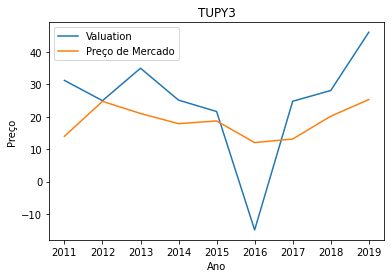

In [129]:
#Gráfico de Preços

#Preços de fechamento de cada ano do valuation (2011,2012,2013,2014,2015,2016,2017,2018,2019) sem ajuste
mp1 = 13.95
mp2 = 24.75
mp3 = 21.00
mp4 = 17.85
mp5 = 18.70
mp6 = 12.01
mp7 = 13.12
mp8 = 20.15
mp9 = 25.30

#Beta 12 meses
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[Preço1_1,Preço1_2,Preço1_3,Preço1_4,Preço1_5,Preço1_6,Preço1_7,Preço1_8,Preço1_9], label='Valuation')
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[mp1,mp2,mp3,mp4,mp5,mp6,mp7,mp8,mp9], label='Preço de Mercado')
plt.title('TUPY3')
plt.legend()
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.show()

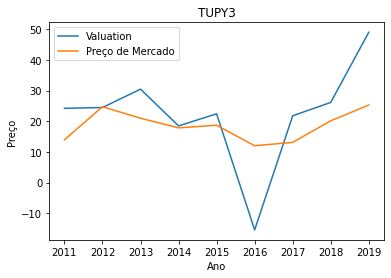

In [130]:
#Beta 36 meses
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[Preço2_1,Preço2_2,Preço2_3,Preço2_4,Preço2_5,Preço2_6,Preço2_7,Preço2_8,Preço2_9], label='Valuation')
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[mp1,mp2,mp3,mp4,mp5,mp6,mp7,mp8,mp9], label='Preço de Mercado')
plt.title('TUPY3')
plt.legend()
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.show()

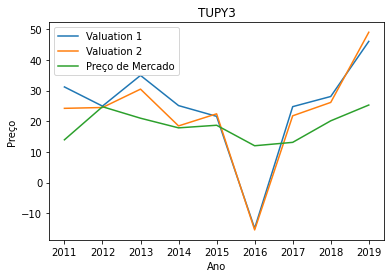

In [131]:
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[Preço1_1,Preço1_2,Preço1_3,Preço1_4,Preço1_5,Preço1_6,Preço1_7,Preço1_8,Preço1_9], label='Valuation 1')
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[Preço2_1,Preço2_2,Preço2_3,Preço2_4,Preço2_5,Preço2_6,Preço2_7,Preço2_8,Preço2_9], label='Valuation 2')
plt.plot([2011,2012,2013,2014,2015,2016,2017,2018,2019],[mp1,mp2,mp3,mp4,mp5,mp6,mp7,mp8,mp9], label='Preço de Mercado')
plt.title('TUPY3')
plt.legend()
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.show()